# <center>Bird Species Identification using Deep Learning<center>

<a id="top"></a>
## Table Of Contents:
### 1. [<font color="#000000">Importing Libraries](#import)
### 2. [<font color="#000000">Defining Support Functions](#function)
### 3. [<font color="#000000">Loading, Exploring and Processing Data](#lep)
### 4. [<font color="#000000">Displaying Random Image Samples from Train, Validation and Test Dataset](#display)
### 5. [<font color="#000000">Dataset Generator](#data)
### 6. [<font color="#000000">Defining Callbacks](#callbacks)
### 7. [<font color="#000000">Building Models](#models)
#### &emsp;&emsp;7.1. [<font color="#000000">Random Model](#ranmod)
#### &emsp;&emsp;7.2. [<font color="#000000">Simple Convolution Model](#mod1)
#### &emsp;&emsp;7.3. [<font color="#000000">InceptionNet Frozen Model](#mod2)
#### &emsp;&emsp;7.4. [<font color="#000000">InceptionNet Finetuned Model](#mod3)
#### &emsp;&emsp;7.5. [<font color="#000000">DenseNet Frozen Model](#mod4)
#### &emsp;&emsp;7.6. [<font color="#000000">DenseNet Finetuned Model](#mod5)
#### &emsp;&emsp;7.7. [<font color="#000000">EfficientNet Frozen Model](#mod6)
#### &emsp;&emsp;7.8. [<font color="#000000">EfficientNet Finetuned Model](#mod7)
### 8. [<font color="#000000">Summary of Performance of all Models](#summary)
### 9. [<font color="#000000">Error Analysis](#error)
### 10. [<font color="#000000">Conclusions](#conclusions)

<a id="import"></a>
### <center>Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
from tqdm import tqdm
import random as rn
import cv2 as cv2
import imgaug.augmenters as iaa

from sklearn.metrics import log_loss, accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Conv2D, BatchNormalization, Flatten, Input, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeUniform, GlorotUniform
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, LearningRateScheduler, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
sns.set_palette("crest_r")
from prettytable import PrettyTable

import warnings
warnings.simplefilter("ignore")
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

<a id="function"></a>
### <center>Defining Support Functions

[<div style="text-align: right"><font color="#000000">Back to Table of Content](#top)

In [2]:
def create_dataframe(root_dir, dataset):
    """This function creates a dataframe that consists of image paths, image species,
    the dataset the images belong to and height and width of the images. It takes the
    root directory path and the dataset for which the dataframe is to be created as
    strings for input."""
    image_root = pathlib.Path(root_dir + dataset + '/')
    image_paths = list(image_root.glob('*/*'))
    image_paths = sorted([str(path) for path in image_paths])
    df = pd.DataFrame(image_paths, columns = ['Filepath'])
    df['Species'] = df['Filepath'].str.split('\\').str[2].str.strip()
    df['Dataset'] = dataset
    width = []
    height = []
    for file in tqdm(df['Filepath']):
        image = cv2.imread(file, cv2.IMREAD_UNCHANGED)
        height.append(image.shape[0])
        width.append(image.shape[1])
    df['Height'] = height
    df['Width'] = width
    return df

In [3]:
def show_images(filepaths, class_labels, aug = None):
    """This function displays 10 random images from the filepaths after performing
    augmentation if augmentation object is provided. It takes filepaths and their
    class label as iterable and augmentation object for input."""
    plt.figure(figsize=(15,6))
    for i, j in enumerate(np.random.randint(0, high = len(filepaths), size = 10)):
        plt.subplot(2, 5, i+1)
        image = cv2.imread(filepaths[j], cv2.IMREAD_UNCHANGED)
        if aug:
            image = aug.augment_image(image)
        plt.imshow(image)
        plt.title(class_labels[j], color = 'maroon')
        plt.axis('off')
    plt.show()

In [4]:
def predict(image_path, model, height, width, preprocess_func = None):
    """This function predicts the probabilities of an image belonging to
    different classes. It takes path to image as string, model as model
    object, height and width as integers, and preprocess function if any
    for input. It returns the probabilities of the image belonging to
    different classes as list, predicted label as integer, top five
    labels and their probabilities as list of tuples."""
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (height, width), interpolation = cv2.INTER_NEAREST)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if preprocess_func == 'scale':
        image *= 1 / 255
    elif preprocess_func:
        image = preprocess_func(image)
    
    image = np.expand_dims(image, axis = 0)
    y_pred_prob = model.predict(image, verbose = 0)
    y_pred = np.argmax(y_pred_prob, axis = 1)
    y_top5_prob = np.sort(y_pred_prob)[:, -1:-6:-1]
    y_top5_label = np.argsort(y_pred_prob)[:, -1:-6:-1]
    top5 = list(zip(y_top5_label[0], y_top5_prob[0]))
    
    return y_pred_prob[0], y_pred[0], top5

In [5]:
def report(test_df, filepath_col, label_col, model, classes, height, width, preprocess_func = None):
    """This function generates the classification report and error report of a
    models predictions. It takes test dataframe which contains filepath and
    label columns, names of filepath and label columns as string, model as
    model object, classes as list, height and width as integers and preprocess
    function if any for input. It returns classification report and error
    report as dataframe, total number of True Positives and False Positives
    as integers and Accuracy as float."""
    Tot_TP = 0
    Tot_FP = 0
    Class_TP = [0 for i in range(len(classes))]
    Class_FP = [0 for i in range(len(classes))]
    Class_FN = [0 for i in range(len(classes))]
    Class_Tot = [0 for i in range(len(classes))]
    
    Image_Path = []
    Pred_Class = []
    True_Class = []
    
    for i in range(test_df.shape[0]):
        if preprocess_func:
            _, y_pred, _ = predict(test_df[filepath_col][i], model, height, width, preprocess_func)
        else:
            _, y_pred, _ = predict(test_df[filepath_col][i], model, height, width)
        y_true = test_df[label_col][i]
        Class_Tot[y_true] += 1
        if y_pred == y_true:
            Tot_TP += 1
            Class_TP[y_pred] += 1
        else:
            Tot_FP += 1
            Class_FP[y_pred] += 1
            Class_FN[y_true] += 1
            
            Image_Path.append(test_df[filepath_col][i])
            Pred_Class.append(classes[y_pred])
            True_Class.append(classes[y_true])
    
    Acc = (Tot_TP * 100) / (Tot_TP + Tot_FP)
    Class_Rep = pd.DataFrame(classes, columns = ['Species'])
    Class_Rep['Total_Images'] = Class_Tot
    Class_Rep['TP'] = Class_TP
    Class_Rep['FP'] = Class_FP
    Class_Rep['FN'] = Class_FN    
    Class_Rep['Precision'] = Class_Rep['TP'] / (Class_Rep['TP'] + Class_Rep['FP'])
    Class_Rep['Recall'] = Class_Rep['TP'] / Class_Rep['Total_Images']
    Class_Rep['F1-Score'] = (2 * Class_Rep['Precision'] * Class_Rep['Recall']) /\
                            (Class_Rep['Precision'] + Class_Rep['Recall'])
    Class_Rep = Class_Rep.round(2)
    
    Err_Rep = pd.DataFrame(Image_Path, columns = ['Image_Path'])
    Err_Rep['Predicted Species'] = Pred_Class
    Err_Rep['True Species'] = True_Class
    
    return Class_Rep, Err_Rep, Tot_TP, Tot_FP, Acc

In [6]:
def analyze(image_path, test_df, filepath_col, class_col, model, true_class, classes, height, width, preprocess_func = None):
    """This function helps us to analyze the prediction of the model visually.
    It takes image path as string, test dataframe which contains filepath and
    class columns, names of filepath and class columns as string, model as
    model object, true class of image as string, classes as list, height and
    width as integers and preprocess function if any for input. It prints the
    provided image with true class and top five classes the image may belong
    to along with predicted probabilities and images of those classes."""
    if preprocess_func:
        _, _, top5 = predict(image_path, model, height, width, preprocess_func)
    else:
        _, _, top5 = predict(image_path, model, height, width)

    plt.figure(figsize=(18,3))
    plt.subplot(1, 6, 1)
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    plt.imshow(image)
    plt.title("True Species:" + true_class, color = 'maroon', fontsize = 9)
    plt.axis('off')
    
    for i in range(5):
        pred_class = classes[top5[i][0]]
        pred_prob = np.round(top5[i][1], 2)
        pred_class_path = test_df[test_df[class_col] == pred_class][filepath_col].values[0]
        plt.subplot(1, 6, i + 2)
        image = cv2.imread(pred_class_path, cv2.IMREAD_UNCHANGED)
        plt.imshow(image)
        plt.title(pred_class + ":" + str(pred_prob), color = 'maroon', fontsize = 9)
        plt.axis('off')   

<a id="lep"></a>
### <center>Loading, Exploring and Processing Data

[<div style="text-align: right"><font color="#000000">Back to Table of Content](#top)

In [7]:
root_dir = 'data/'
train_dir = 'train/'
valid_dir = 'valid/'
test_dir = 'test/'

In [8]:
train_classes = set(os.listdir(root_dir + train_dir))
valid_classes = set(os.listdir(root_dir + valid_dir))
test_classes = set(os.listdir(root_dir + test_dir))
assert train_classes == valid_classes == test_classes

AssertionError: 

During exploring, we found that their are double whitespaces present in some species folder's name of train, validation and test datasets. These folder names will be used as classes/target for classification, so they should be same in train, validation and test datasets. We will be renaming these species folders to replace double whitespaces with single whitespace.

In [9]:
os.rename(src = root_dir + train_dir + "BLACK & YELLOW  BROADBILL", dst = root_dir + train_dir + "BLACK & YELLOW BROADBILL")
os.rename(src = root_dir + train_dir + "COCK OF THE  ROCK", dst = root_dir + train_dir + "COCK OF THE ROCK")
os.rename(src = root_dir + train_dir + "ELLIOTS  PHEASANT", dst = root_dir + train_dir + "ELLIOTS PHEASANT")
os.rename(src = root_dir + train_dir + "MIKADO  PHEASANT", dst = root_dir + train_dir + "MIKADO PHEASANT")
os.rename(src = root_dir + train_dir + "PARAKETT  AKULET", dst = root_dir + train_dir + "PARAKETT AKULET")

In [10]:
os.rename(src = root_dir + valid_dir + "COCK OF THE  ROCK", dst = root_dir + valid_dir + "COCK OF THE ROCK")
os.rename(src = root_dir + valid_dir + "ELLIOTS  PHEASANT", dst = root_dir + valid_dir + "ELLIOTS PHEASANT")
os.rename(src = root_dir + valid_dir + "MIKADO  PHEASANT", dst = root_dir + valid_dir + "MIKADO PHEASANT")
os.rename(src = root_dir + valid_dir + "PARAKETT  AKULET", dst = root_dir + valid_dir + "PARAKETT AKULET")

In [11]:
os.rename(src = root_dir + test_dir + "COCK OF THE  ROCK", dst = root_dir + test_dir + "COCK OF THE ROCK")
os.rename(src = root_dir + test_dir + "ELLIOTS  PHEASANT", dst = root_dir + test_dir + "ELLIOTS PHEASANT")
os.rename(src = root_dir + test_dir + "MIKADO  PHEASANT", dst = root_dir + test_dir + "MIKADO PHEASANT")
os.rename(src = root_dir + test_dir + "PARAKETT  AKULET", dst = root_dir + test_dir + "PARAKETT AKULET")

In [12]:
train_classes = set(os.listdir(root_dir + train_dir))
valid_classes = set(os.listdir(root_dir + valid_dir))
test_classes = set(os.listdir(root_dir + test_dir))
assert train_classes == valid_classes == test_classes

#### Creating DataFrame containing Image details of train, validation and test set.

In [13]:
label_dict = {s:i for i, s in enumerate(sorted(os.listdir(root_dir + train_dir)))}
print(label_dict)

{'ABBOTTS BABBLER': 0, 'ABBOTTS BOOBY': 1, 'ABYSSINIAN GROUND HORNBILL': 2, 'AFRICAN CROWNED CRANE': 3, 'AFRICAN EMERALD CUCKOO': 4, 'AFRICAN FIREFINCH': 5, 'AFRICAN OYSTER CATCHER': 6, 'ALBATROSS': 7, 'ALBERTS TOWHEE': 8, 'ALEXANDRINE PARAKEET': 9, 'ALPINE CHOUGH': 10, 'ALTAMIRA YELLOWTHROAT': 11, 'AMERICAN AVOCET': 12, 'AMERICAN BITTERN': 13, 'AMERICAN COOT': 14, 'AMERICAN GOLDFINCH': 15, 'AMERICAN KESTREL': 16, 'AMERICAN PIPIT': 17, 'AMERICAN REDSTART': 18, 'AMETHYST WOODSTAR': 19, 'ANDEAN GOOSE': 20, 'ANDEAN LAPWING': 21, 'ANDEAN SISKIN': 22, 'ANHINGA': 23, 'ANIANIAU': 24, 'ANNAS HUMMINGBIRD': 25, 'ANTBIRD': 26, 'ANTILLEAN EUPHONIA': 27, 'APAPANE': 28, 'APOSTLEBIRD': 29, 'ARARIPE MANAKIN': 30, 'ASHY THRUSHBIRD': 31, 'ASIAN CRESTED IBIS': 32, 'AVADAVAT': 33, 'AZURE JAY': 34, 'AZURE TANAGER': 35, 'AZURE TIT': 36, 'BAIKAL TEAL': 37, 'BALD EAGLE': 38, 'BALD IBIS': 39, 'BALI STARLING': 40, 'BALTIMORE ORIOLE': 41, 'BANANAQUIT': 42, 'BAND TAILED GUAN': 43, 'BANDED BROADBILL': 44, 'BANDED 

In [14]:
train_df = create_dataframe(root_dir, 'train')
train_df['Label'] = train_df['Species'].map(label_dict)
train_df.head()

100%|███████████████████████████████████████████████████████████████████████████| 58388/58388 [06:24<00:00, 151.76it/s]


Filepath          Species Dataset  Height  Width  \
0  data\train\ABBOTTS BABBLER\001.jpg  ABBOTTS BABBLER   train     224    224   
1  data\train\ABBOTTS BABBLER\002.jpg  ABBOTTS BABBLER   train     224    224   
2  data\train\ABBOTTS BABBLER\003.jpg  ABBOTTS BABBLER   train     224    224   
3  data\train\ABBOTTS BABBLER\004.jpg  ABBOTTS BABBLER   train     224    224   
4  data\train\ABBOTTS BABBLER\005.jpg  ABBOTTS BABBLER   train     224    224   

   Label  
0      0  
1      0  
2      0  
3      0  
4      0

In [15]:
valid_df = create_dataframe(root_dir, 'valid')
valid_df['Label'] = valid_df['Species'].map(label_dict)
valid_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 150.39it/s]


Filepath          Species Dataset  Height  Width  \
0  data\valid\ABBOTTS BABBLER\1.jpg  ABBOTTS BABBLER   valid     224    224   
1  data\valid\ABBOTTS BABBLER\2.jpg  ABBOTTS BABBLER   valid     224    224   
2  data\valid\ABBOTTS BABBLER\3.jpg  ABBOTTS BABBLER   valid     224    224   
3  data\valid\ABBOTTS BABBLER\4.jpg  ABBOTTS BABBLER   valid     224    224   
4  data\valid\ABBOTTS BABBLER\5.jpg  ABBOTTS BABBLER   valid     224    224   

   Label  
0      0  
1      0  
2      0  
3      0  
4      0

In [16]:
test_df = create_dataframe(root_dir, 'test')
test_df['Label'] = test_df['Species'].map(label_dict)
test_df.head()

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1226.49it/s]


Filepath          Species Dataset  Height  Width  \
0  data\test\ABBOTTS BABBLER\1.jpg  ABBOTTS BABBLER    test     224    224   
1  data\test\ABBOTTS BABBLER\2.jpg  ABBOTTS BABBLER    test     224    224   
2  data\test\ABBOTTS BABBLER\3.jpg  ABBOTTS BABBLER    test     224    224   
3  data\test\ABBOTTS BABBLER\4.jpg  ABBOTTS BABBLER    test     224    224   
4  data\test\ABBOTTS BABBLER\5.jpg  ABBOTTS BABBLER    test     224    224   

   Label  
0      0  
1      0  
2      0  
3      0  
4      0

In [17]:
birds_df = pd.concat([train_df, valid_df, test_df], axis = 0, ignore_index = True)
birds_df.to_csv("data/birds_species.csv", index = False)

#### Number of Images for each Species in train, validation and test set.

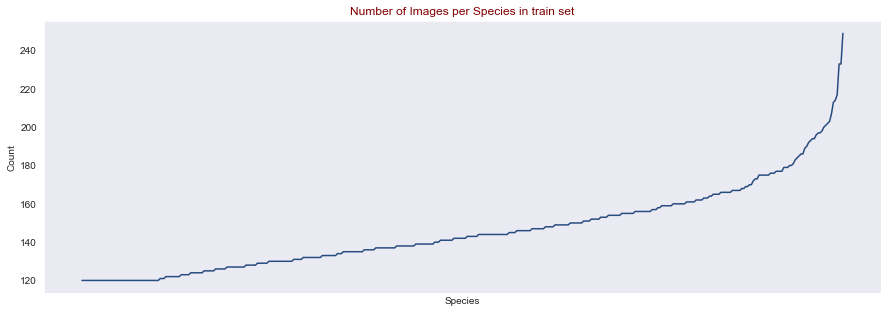

In [18]:
tr = train_df['Species'].value_counts().sort_values()
plt.figure(figsize = [15,5])
sns.lineplot(x = tr.index, y = tr.values)
plt.xlabel("Species")
plt.ylabel("Count")
plt.xticks([])
plt.title("Number of Images per Species in train set", color = 'maroon')
plt.show()

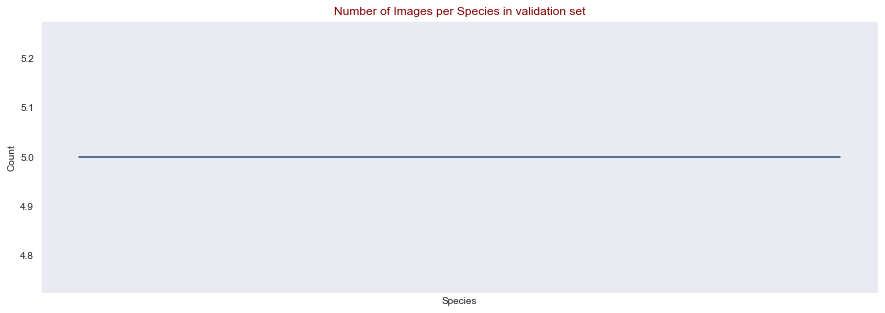

In [19]:
va = valid_df['Species'].value_counts().sort_values()
plt.figure(figsize = [15,5])
sns.lineplot(x = va.index, y = va.values)
plt.xlabel("Species")
plt.ylabel("Count")
plt.xticks([])
plt.title("Number of Images per Species in validation set", color = 'maroon')
plt.show()

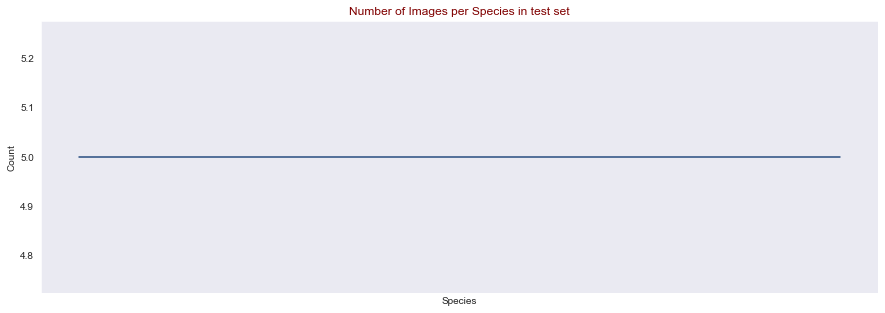

In [20]:
te = test_df['Species'].value_counts().sort_values()
plt.figure(figsize = [15,5])
sns.lineplot(x = te.index, y = te.values)
plt.xlabel("Species")
plt.ylabel("Count")
plt.xticks([])
plt.title("Number of Images per Species in test set", color = 'maroon')
plt.show()

The number of images per species in training set is not perfectly balanced and varies from 120 to 250 image files. However, the test and the validation set are balanced containing 5 images per species for each dataset.

#### Width and Height of Images in train, validation and test set.

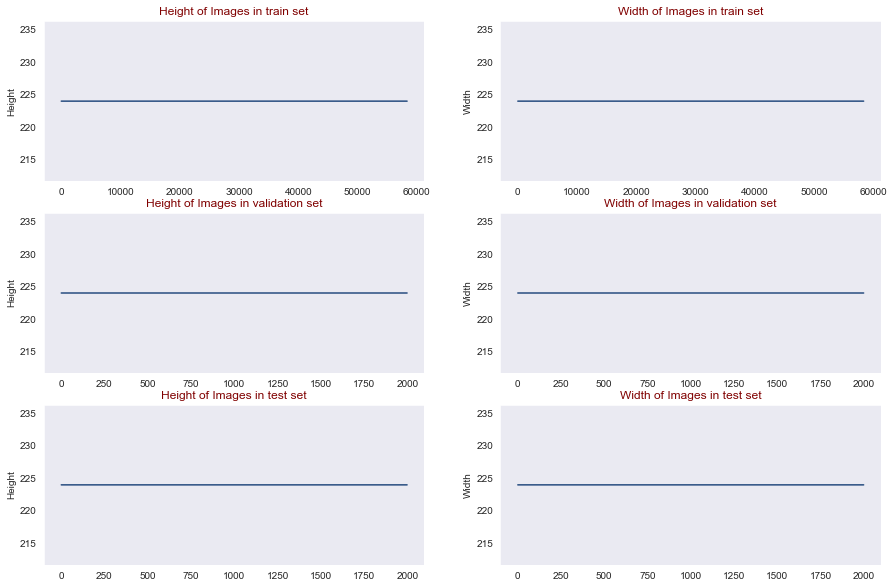

In [21]:
plt.figure(figsize = [15,10])
plt.subplot(3,2,1)
sns.lineplot(data = train_df['Height'])
plt.ylabel("Height")
plt.title("Height of Images in train set", color = 'maroon')
plt.subplot(3,2,2)
sns.lineplot(data = train_df['Width'])
plt.ylabel("Width")
plt.title("Width of Images in train set", color = 'maroon')
plt.subplot(3,2,3)
sns.lineplot(data = valid_df['Height'])
plt.ylabel("Height")
plt.title("Height of Images in validation set", color = 'maroon')
plt.subplot(3,2,4)
sns.lineplot(data = valid_df['Width'])
plt.ylabel("Width")
plt.title("Width of Images in validation set", color = 'maroon')
plt.subplot(3,2,5)
sns.lineplot(data = test_df['Height'])
plt.ylabel("Height")
plt.title("Height of Images in test set", color = 'maroon')
plt.subplot(3,2,6)
sns.lineplot(data = test_df['Width'])
plt.ylabel("Width")
plt.title("Width of Images in test set", color = 'maroon')
plt.show()

All the images in train, validation and test set have height of 224 and width of 224. No anomaly in size of any image was found.

<a id="display"></a>
### <center>Displaying Random Image Samples from Train, Validation and Test Dataset

[<div style="text-align: right"><font color="#000000">Back to Table of Content](#top)

We are displaying random image samples from train, validation and test set to get an idea about the images. We are also displaying random augmented images from train set which will be used for training the models. We will be performing augmentation on train dataset since it helps to artificially increase the train dataset size reducing overfitting of the model thus reducing generalisation error.

In [22]:
aug = iaa.SomeOf((0, 2),[
    iaa.Fliplr(1),
    iaa.Flipud(1),
    iaa.Affine(rotate = (-45, 45), mode = 'edge'),
    iaa.Affine(shear = (-20, 20), mode = 'edge'),
    iaa.Affine(scale = (0.8, 1.2), mode = 'edge'),
    iaa.Affine(translate_percent = {"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, mode = 'edge'),
    iaa.Multiply((0.8, 1.2), per_channel = 0.3),
])

Random train Images without Augmentation


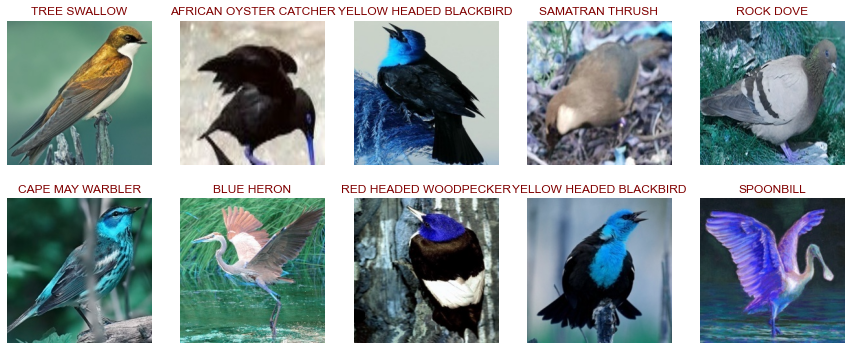

In [23]:
print("Random train Images without Augmentation")
show_images(train_df['Filepath'], train_df['Species'])

Random train Images with Augmentation


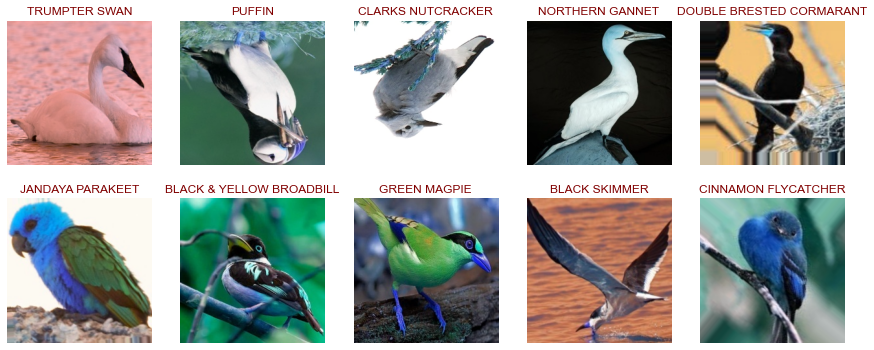

In [24]:
print("Random train Images with Augmentation")
show_images(train_df['Filepath'], train_df['Species'], aug)

Random validation Images without Augmentation


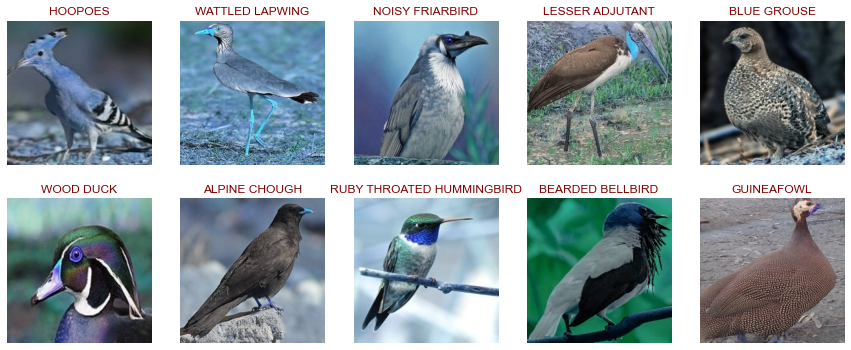

In [25]:
print("Random validation Images without Augmentation")
show_images(valid_df['Filepath'], valid_df['Species'])

Random test Images without Augmentation


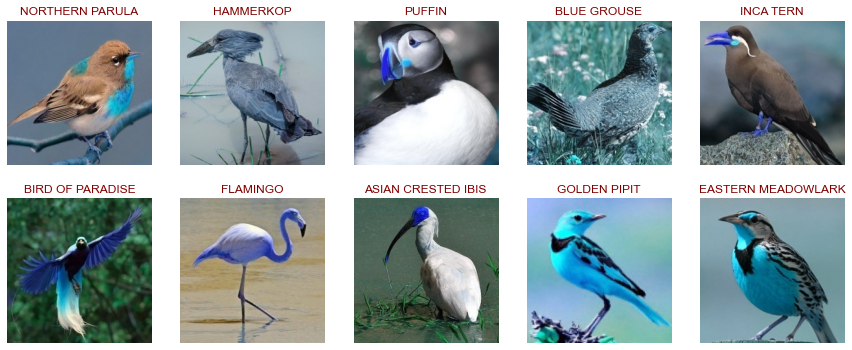

In [26]:
print("Random test Images without Augmentation")
show_images(test_df['Filepath'], test_df['Species'])

<a id="data"></a>
### <center>Dataset Generator

[<div style="text-align: right"><font color="#000000">Back to Table of Content](#top)

In [2]:
birds_df = pd.read_csv("data/birds_species.csv")
train_df = birds_df[birds_df['Dataset'] == 'train'].reset_index()
valid_df = birds_df[birds_df['Dataset'] == 'valid'].reset_index()
test_df = birds_df[birds_df['Dataset'] == 'test'].reset_index()

In [3]:
classes = birds_df['Species'].unique()
labels = birds_df['Label'].unique()
num_class = len(birds_df['Label'].unique())

In [4]:
def data_generator(df, filepath_col, label_col, b_size, height, width, process_func = None, is_train = False):
    """This function generates an ImageDataGenerator object for batchwise loading
    of images. The function performs random augmentations only on train images and
    preprocessing on datasets if preprocessing function is provided. It takes
    dataframe containing images filepath and labels, columns names of filepath and
    labels as string, batch size as integer, height and width of the resized images
    as integer, preprocessing function if any and train dataset boolean flag
    for input."""
    if is_train:
        if process_func == 'scale':
            dataset = ImageDataGenerator(horizontal_flip = True, vertical_flip = True, rotation_range = 45, shear_range = 20,
                                         brightness_range = (0.8, 1.2), width_shift_range = 0.2, height_shift_range = 0.2,
                                         zoom_range = (0.8, 1.2), rescale = 1 / 255)
        elif process_func:
            dataset = ImageDataGenerator(horizontal_flip = True, vertical_flip = True, rotation_range = 45, shear_range = 20,
                                         brightness_range = (0.8, 1.2), width_shift_range = 0.2, height_shift_range = 0.2,
                                         zoom_range = (0.8, 1.2), preprocessing_function = process_func)
        else:
            dataset = ImageDataGenerator(horizontal_flip = True, vertical_flip = True, rotation_range = 45, shear_range = 20,
                                         brightness_range = (0.8, 1.2), width_shift_range = 0.2, height_shift_range = 0.2,
                                         zoom_range = (0.8, 1.2))
    else:
        if process_func == 'scale':
            dataset = ImageDataGenerator(rescale = 1 / 255)
        elif process_func:
            dataset = ImageDataGenerator(preprocessing_function = process_func)
        else:
            dataset = ImageDataGenerator()

    dataloader = dataset.flow_from_dataframe(df, x_col = filepath_col, y_col = label_col, class_mode = "categorical",
                                             batch_size = b_size, target_size = (height, width), interpolation = 'nearest')
    return dataloader

<a id="callbacks"></a>
### <center>Defining Callbacks

[<div style="text-align: right"><font color="#000000">Back to Table of Content](#top)

This is a custom callback which includes the functions of Learning Rate Scheduler, Reduce Learning Rate on Plateau, Early Stopping and Model Checkpoint. In addition it provides summary of the model's performance at the end of each epoch. It also provides a handy feature that enables us to stop or continue training if the model's performance has not improved for specified number of epochs. This is very useful when we are training a model and decide the metrics are satisfactory and want to end the model training early. Also, it allows switching from validation accuracy to validation loss (cross-entropy) to monitor model's performance after a certain specified threshold, as near model's peak performance, the validation accuracy may not improve even when the validation loss decreases.

In [5]:
class CustomCallbacks(tf.keras.callbacks.Callback):
    def __init__(self, threshold, model_name, stop_patience, schedule_lr_patience, schedule_lr_factor, reduce_lr_patience,
                 reduce_lr_factor):
        self.threshold = threshold
        self.model_name = model_name
        self.stop_patience = stop_patience
        self.schedule_lr_patience = schedule_lr_patience
        self.schedule_lr_factor = schedule_lr_factor
        self.reduce_lr_patience = reduce_lr_patience
        self.reduce_lr_factor = reduce_lr_factor
        self.min_val_loss = np.inf
        self.max_val_acc = 0.0
        self.best_epoch = np.nan
        self.acc_counter = 0
        self.loss_counter = 0

    def on_epoch_end(self, epoch, logs = {}):
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_accuracy')
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        logs['lr'] = lr
        
        if val_acc <= self.threshold:
            self.loss_counter = 0
            if val_acc <= self.max_val_acc:
                self.acc_counter += 1
                if val_loss < self.min_val_loss:
                    self.min_val_loss = val_loss
            else:
                self.max_val_acc = val_acc
                self.best_epoch = epoch + 1
                if val_loss < self.min_val_loss:
                    self.min_val_loss = val_loss
                self.acc_counter = 0
                filepath = "data/models/" + self.model_name + "/{a:.4f}-{b:.4f}.h5".format(a = val_loss, b = val_acc)
                self.model.save(filepath)
            
            if self.acc_counter >= self.reduce_lr_patience:
                lr *= self.reduce_lr_factor
                tf.keras.backend.set_value(self.model.optimizer.lr, lr)
            
            if self.acc_counter == self.stop_patience:
                print("\nValidation accuracy hasn't increased for last", self.stop_patience, "epochs. Do you want to stop\
                training? Y/N")
                ans = str.lower(input())
                while ans != 'y' and ans != 'n':
                    print("Invalid input. Please enter 'Y' or 'N'.")
                    ans = str.lower(input())
                else:
                    if ans == 'y':
                        print("Training has been terminated after {} epochs.".format(epoch + 1))
                        self.model.stop_training = True
                    else:
                        print("Continuing Training")
                        self.acc_counter = 0
        else:
            self.acc_counter = 0
            if val_loss >= self.min_val_loss:
                self.loss_counter += 1
                if val_acc > self.max_val_acc:
                    self.max_val_acc = val_acc
            else:
                self.min_val_loss = val_loss
                self.best_epoch = epoch + 1
                if val_acc > self.max_val_acc:
                    self.max_val_acc = val_acc
                self.loss_counter = 0
                filepath = "data/models/" + model_name + "/{a:.4f}-{b:.4f}.h5".format(a = val_loss, b = val_acc)
                self.model.save(filepath)
            
            if self.loss_counter >= self.reduce_lr_patience:
                lr *= self.reduce_lr_factor
                tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                
            if self.loss_counter == self.stop_patience:
                print("\nValidation Loss hasn't decreased for last", self.stop_patience, "epochs. Do you want to stop\
                training? Y/N")
                ans = str.lower(input())
                while ans != 'y' and ans != 'n':
                    print("Invalid input. Please enter 'Y' or 'N'.")
                    ans = str.lower(input())
                else:
                    if ans == 'y':
                        print("Training has been terminated after {} epochs.".format(epoch + 1))
                        self.model.stop_training = True
                    else:
                        print("Continuing Training")
                        self.loss_counter = 0
        
        if (epoch + 1) % schedule_lr_patience == 0:
            lr *= self.schedule_lr_factor
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        
        logs['next_lr'] = lr
        logs['best_val_accuracy'] = self.max_val_acc
        logs['best_val_loss'] = self.min_val_loss
        logs['best_epoch'] = self.best_epoch

In [6]:
def callbacks(model_name, threshold, stop_patience, schedule_lr_patience, schedule_lr_factor, reduce_lr_patience,
              reduce_lr_factor):
    """This function generates list of callbacks and returns it. It takes
    model's name as string and threshold, stop patience, schedule learning
    rate patience, schedule lerning rate factor, reduce learning rate
    patience and reduce learning rate factor as int for input."""
    Custom = CustomCallbacks(threshold, model_name, stop_patience, schedule_lr_patience, schedule_lr_factor,
                             reduce_lr_patience, reduce_lr_factor)
    log_dir = os.path.join("data/models", model_name, datetime.now().strftime("%Y%m%d-%H%M%S"))
    Tensorboard = TensorBoard(log_dir = log_dir)

    return [Custom, Tensorboard]

<a id="models"></a>
### <center>Building Models

We are building various models from simple 3-4 layered convolution model to using transfer learning on various convolution networks such as VGG16, ResNet, Inception, DenseNet and EfficientNet. We will analyse the performance of all the model and use the model with best performance for deployment.

<a id="ranmod"></a>
#### <center>Random Model

[<div style="text-align: right"><font color="#000000">Back to Table of Content](#top)

A Random model is a model which randomly generates the probabilities for an observation to belong to different classes. The randomly generated probabilities for all classes sum upto 1. The Random model provides us a baseline for the loss and the performance metric.

In [7]:
def random_model(labels, num_class):
    """This function calculates loss and accuracy of a random model and returns
    them. It takes true labels as input."""
    y_prob = []
    y_pred = []
    for i in range(len(labels)):
        pred_prob = np.random.uniform(size = num_class)
        pred_prob /= sum(pred_prob)
        y_prob.append(pred_prob)
        y_pred.append(np.argmax(pred_prob))
    loss = log_loss(labels, y_prob)
    acc = accuracy_score(labels, y_pred)

    return loss, acc

In [8]:
ran_test_loss, ran_test_acc = random_model(test_df['Label'], num_class)

In [9]:
print("Random Model test loss:", ran_test_loss, "\nRandom Model test accuracy:", ran_test_acc)

Random Model test loss: 6.316259193302194 
Random Model test accuracy: 0.0035


<a id="mod1"></a>
#### <center>Simple Convolution Model

[<div style="text-align: right"><font color="#000000">Back to Table of Content](#top)

Our Simple Convolution models consists of five convolution layers, two average pooling layers and a dropout layer. The images are resized to height of 128 and width of 128.

In [7]:
tf.keras.backend.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)
tf.random.set_seed(0)

In [8]:
model_name = "Simple_Convolution"
threshold = 0.5
stop_patience = 5
schedule_lr_patience = 3
schedule_lr_factor = 0.9
reduce_lr_patience = 2
reduce_lr_factor = 0.5
h = 128
w = 128
BATCH_SIZE = 32

In [9]:
train_dataloader = data_generator(train_df, "Filepath", "Species", BATCH_SIZE, h, w, 'scale', is_train = True)
valid_dataloader = data_generator(valid_df, "Filepath", "Species", BATCH_SIZE, h, w, 'scale')
test_dataloader = data_generator(test_df, "Filepath", "Species", BATCH_SIZE, h, w, 'scale')

Found 58388 validated image filenames belonging to 400 classes.
Found 2000 validated image filenames belonging to 400 classes.
Found 2000 validated image filenames belonging to 400 classes.


In [10]:
input_layer = Input(shape = (h , w, 3))
conv1 = Conv2D(32, 3, padding = 'same', strides = 2, kernel_initializer = HeUniform(seed = 3))(input_layer)
bn1 = BatchNormalization()(conv1)
act1 = Activation("relu")(bn1)
conv2 = Conv2D(64, 3, padding = 'same', strides = 2, kernel_initializer = HeUniform(seed = 6))(act1)
bn2 = BatchNormalization()(conv2)
act2 = Activation("relu")(bn2)
pool1 = AveragePooling2D(pool_size = (2, 2))(act2)
conv3 = Conv2D(128, 3, padding = 'same', strides = 2, kernel_initializer = HeUniform(seed = 9))(pool1)
bn3 = BatchNormalization()(conv3)
act3 = Activation("relu")(bn3)
conv4 = Conv2D(256, 3, padding = 'same', strides = 2, kernel_initializer = HeUniform(seed = 12))(act3)
bn4 = BatchNormalization()(conv4)
act4 = Activation("relu")(bn4)
pool2 = AveragePooling2D(pool_size = (2, 2))(act4)
conv5 = Conv2D(512, 3, padding = 'same', strides = 2, kernel_initializer = HeUniform(seed = 15))(pool2)
bn5 = BatchNormalization()(conv5)
act5 = Activation("relu")(bn5)
flat = Flatten()(act5)
drop = Dropout(0.1)(flat)
output_layer = Dense(num_class, activation = "softmax", kernel_initializer = GlorotUniform(seed = 18))(drop)

model1 = Model(inputs = input_layer, outputs = output_layer, name = model_name)

In [11]:
try:
    os.mkdir("data/models/" + model_name)
except:
    ""
dot_img_file = 'data/models/' + model_name + '/Plot.png'
tf.keras.utils.plot_model(model1, to_file = dot_img_file, show_shapes = True)
model1.summary(show_trainable = True)

Model: "Simple_Convolution"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         Y          
                                                                            
 conv2d (Conv2D)             (None, 64, 64, 32)        896       Y          
                                                                            
 batch_normalization (BatchN  (None, 64, 64, 32)       128       Y          
 ormalization)                                                              
                                                                            
 activation (Activation)     (None, 64, 64, 32)        0         Y          
                                                                            
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     Y          
                                                

In [12]:
optimizer = Adam(0.001)
callback_lst = callbacks(model_name, threshold, stop_patience, schedule_lr_patience, schedule_lr_factor, reduce_lr_patience,
                         reduce_lr_factor)
model1.compile(optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [13]:
%%time
model1.fit(train_dataloader, steps_per_epoch = len(train_dataloader), epochs = 50, validation_data = valid_dataloader,
           callbacks = callback_lst)

Epoch 1/50
1825/1825 [==============================] - 622s 338ms/step - loss: 4.8332 - accuracy: 0.0685 - val_loss: 6.8849 - val_accuracy: 0.0295 - lr: 0.0010 - next_lr: 0.0010 - best_val_accuracy: 0.0295 - best_val_loss: 6.8849 - best_epoch: 1.0000
Epoch 2/50
1825/1825 [==============================] - 317s 174ms/step - loss: 3.8365 - accuracy: 0.1699 - val_loss: 5.0407 - val_accuracy: 0.1145 - lr: 0.0010 - next_lr: 0.0010 - best_val_accuracy: 0.1145 - best_val_loss: 5.0407 - best_epoch: 2.0000
Epoch 3/50
1825/1825 [==============================] - 316s 173ms/step - loss: 3.3765 - accuracy: 0.2423 - val_loss: 2.8024 - val_accuracy: 0.3475 - lr: 0.0010 - next_lr: 9.0000e-04 - best_val_accuracy: 0.3475 - best_val_loss: 2.8024 - best_epoch: 3.0000
Epoch 4/50
1825/1825 [==============================] - 316s 173ms/step - loss: 3.0498 - accuracy: 0.3009 - val_loss: 3.4504 - val_accuracy: 0.2570 - lr: 9.0000e-04 - next_lr: 9.0000e-04 - best_val_accuracy: 0.3475 - best_val_loss: 2.8024 -

Epoch 32/50
1825/1825 [==============================] - 314s 172ms/step - loss: 1.4150 - accuracy: 0.6377 - val_loss: 1.3246 - val_accuracy: 0.6680 - lr: 1.3620e-06 - next_lr: 1.3620e-06 - best_val_accuracy: 0.6705 - best_val_loss: 1.2935 - best_epoch: 26.0000
Epoch 33/50
1825/1825 [==============================] - 312s 171ms/step - loss: 1.4144 - accuracy: 0.6346 - val_loss: 1.3403 - val_accuracy: 0.6665 - lr: 1.3620e-06 - next_lr: 6.1291e-07 - best_val_accuracy: 0.6705 - best_val_loss: 1.2935 - best_epoch: 26.0000
Epoch 34/50
1825/1825 [==============================] - 316s 173ms/step - loss: 1.4247 - accuracy: 0.6323 - val_loss: 1.3417 - val_accuracy: 0.6655 - lr: 6.1291e-07 - next_lr: 3.0646e-07 - best_val_accuracy: 0.6705 - best_val_loss: 1.2935 - best_epoch: 26.0000
Epoch 35/50
1825/1825 [==============================] - 314s 172ms/step - loss: 1.4144 - accuracy: 0.6380 - val_loss: 1.3433 - val_accuracy: 0.6660 - lr: 3.0646e-07 - next_lr: 1.5323e-07 - best_val_accuracy: 0.670

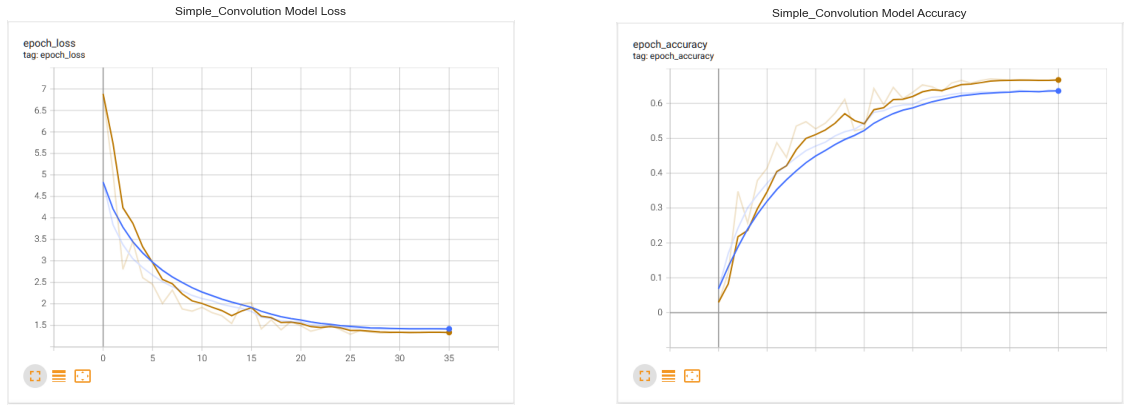

In [14]:
plt.figure(figsize = [20,15])
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread("data\models\\" + model_name + "\Loss.png", cv2.IMREAD_UNCHANGED))
plt.title(model_name + " Model Loss")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread("data\models\\" + model_name + "\Accuracy.png", cv2.IMREAD_UNCHANGED))
plt.title(model_name + " Model Accuracy")
plt.axis('off')
plt.show()

In [15]:
model1 = load_model("data/models/Simple_Convolution/1.2935-0.6660.h5")
eval_test = model1.evaluate(test_dataloader, verbose = 0)
mod1_test_loss = eval_test[0]
mod1_test_acc = eval_test[1]

In [16]:
print("Simple Convolution Model test loss:", mod1_test_loss,
      "\nSimple Convolution Model test accuracy:", mod1_test_acc)

Simple Convolution Model test loss: 1.1851749420166016 
Simple Convolution Model test accuracy: 0.6890000104904175


<a id="mod2"></a>
#### <center>InceptionNet Frozen Model

[<div style="text-align: right"><font color="#000000">Back to Table of Content](#top)

The first model we will use for transfer learning is Inception Network version 3. We will only use the convolution base of the Inceprtion Network with imagenet weights loaded. We will use our own classifier on top of Inception Network. In this model, we will freeze the Convolution Base of Inception Network and train only the top classifier. We will again use images resized to height of 128 and width of 128 for this model.

In [7]:
tf.keras.backend.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)
tf.random.set_seed(0)

In [8]:
model_name = "Inception_Frozen"
threshold = 0.75
stop_patience = 5
schedule_lr_patience = 3
schedule_lr_factor = 0.9
reduce_lr_patience = 2
reduce_lr_factor = 0.5
h = 128
w = 128
BATCH_SIZE = 256

In [9]:
preprocess_func = tf.keras.applications.inception_v3.preprocess_input

In [10]:
train_dataloader = data_generator(train_df, "Filepath", "Species", BATCH_SIZE, h, w, preprocess_func, is_train = True)
valid_dataloader = data_generator(valid_df, "Filepath", "Species", BATCH_SIZE, h, w, preprocess_func)
test_dataloader = data_generator(test_df, "Filepath", "Species", BATCH_SIZE, h, w, preprocess_func)

Found 58388 validated image filenames belonging to 400 classes.
Found 2000 validated image filenames belonging to 400 classes.
Found 2000 validated image filenames belonging to 400 classes.


In [11]:
inception_model = tf.keras.applications.inception_v3.InceptionV3(include_top = False, weights = 'imagenet',
                                                                 input_shape = (h, w, 3))
for layer in inception_model.layers:
    layer.trainable = False

In [12]:
conv = Conv2D(1024, 2, kernel_initializer = HeUniform(seed = 3))(inception_model.layers[-1].output)
bn = BatchNormalization()(conv)
act = Activation("relu")(bn)
flat = Flatten()(act)
drop = Dropout(0.1)(flat)
output_layer = Dense(num_class, activation = "softmax", kernel_initializer = GlorotUniform(seed = 6))(drop)

model2 = Model(inputs = inception_model.inputs, outputs = output_layer, name = model_name)

In [13]:
try:
    os.mkdir("data/models/" + model_name)
except:
    ""
dot_img_file = 'data/models/' + model_name + '/Plot.png'
tf.keras.utils.plot_model(model2, to_file = dot_img_file, show_shapes = True)
model2.summary(show_trainable = True)

Model: "Inception_Frozen"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               N          
                                )]                                                                           
                                                                                                             
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                N          
                                                                                                             
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 N          
 alization)                                                                                   

 conv2d_11 (Conv2D)             (None, 13, 13, 32)   6144        ['average_pooling2d[0][0]']      N          
                                                                                                             
 batch_normalization_5 (BatchNo  (None, 13, 13, 64)  192         ['conv2d_5[0][0]']               N          
 rmalization)                                                                                                
                                                                                                             
 batch_normalization_7 (BatchNo  (None, 13, 13, 64)  192         ['conv2d_7[0][0]']               N          
 rmalization)                                                                                                
                                                                                                             
 batch_normalization_10 (BatchN  (None, 13, 13, 96)  288         ['conv2d_10[0][0]']              N          
 ormalizat

                                                                                                             
 activation_12 (Activation)     (None, 13, 13, 64)   0           ['batch_normalization_12[0][0]'  N          
                                                                 ]                                           
                                                                                                             
 activation_14 (Activation)     (None, 13, 13, 64)   0           ['batch_normalization_14[0][0]'  N          
                                                                 ]                                           
                                                                                                             
 activation_17 (Activation)     (None, 13, 13, 96)   0           ['batch_normalization_17[0][0]'  N          
                                                                 ]                                           
          

                                                                 ]                                           
                                                                                                             
 mixed2 (Concatenate)           (None, 13, 13, 288)  0           ['activation_19[0][0]',          N          
                                                                  'activation_21[0][0]',                     
                                                                  'activation_24[0][0]',                     
                                                                  'activation_25[0][0]']                     
                                                                                                             
 conv2d_27 (Conv2D)             (None, 13, 13, 64)   18432       ['mixed2[0][0]']                 N          
                                                                                                             
 batch_nor

                                                                 ]                                           
                                                                                                             
 conv2d_32 (Conv2D)             (None, 6, 6, 128)    114688      ['activation_31[0][0]']          N          
                                                                                                             
 conv2d_37 (Conv2D)             (None, 6, 6, 128)    114688      ['activation_36[0][0]']          N          
                                                                                                             
 batch_normalization_32 (BatchN  (None, 6, 6, 128)   384         ['conv2d_32[0][0]']              N          
 ormalization)                                                                                               
                                                                                                             
 batch_nor

                                                                                                             
 conv2d_46 (Conv2D)             (None, 6, 6, 160)    179200      ['activation_45[0][0]']          N          
                                                                                                             
 batch_normalization_41 (BatchN  (None, 6, 6, 160)   480         ['conv2d_41[0][0]']              N          
 ormalization)                                                                                               
                                                                                                             
 batch_normalization_46 (BatchN  (None, 6, 6, 160)   480         ['conv2d_46[0][0]']              N          
 ormalization)                                                                                               
                                                                                                             
 activatio

                                                                                                             
 activation_54 (Activation)     (None, 6, 6, 160)    0           ['batch_normalization_54[0][0]'  N          
                                                                 ]                                           
                                                                                                             
 conv2d_55 (Conv2D)             (None, 6, 6, 160)    179200      ['activation_54[0][0]']          N          
                                                                                                             
 batch_normalization_55 (BatchN  (None, 6, 6, 160)   480         ['conv2d_55[0][0]']              N          
 ormalization)                                                                                               
                                                                                                             
 activatio

                                                                                                             
 activation_59 (Activation)     (None, 6, 6, 192)    0           ['batch_normalization_59[0][0]'  N          
                                                                 ]                                           
                                                                                                             
 mixed6 (Concatenate)           (None, 6, 6, 768)    0           ['activation_50[0][0]',          N          
                                                                  'activation_53[0][0]',                     
                                                                  'activation_58[0][0]',                     
                                                                  'activation_59[0][0]']                     
                                                                                                             
 conv2d_64

 ormalization)                                                                                               
                                                                                                             
 batch_normalization_69 (BatchN  (None, 6, 6, 192)   576         ['conv2d_69[0][0]']              N          
 ormalization)                                                                                               
                                                                                                             
 activation_60 (Activation)     (None, 6, 6, 192)    0           ['batch_normalization_60[0][0]'  N          
                                                                 ]                                           
                                                                                                             
 activation_63 (Activation)     (None, 6, 6, 192)    0           ['batch_normalization_63[0][0]'  N          
          

                                                                                                             
 conv2d_80 (Conv2D)             (None, 2, 2, 448)    573440      ['mixed8[0][0]']                 N          
                                                                                                             
 batch_normalization_80 (BatchN  (None, 2, 2, 448)   1344        ['conv2d_80[0][0]']              N          
 ormalization)                                                                                               
                                                                                                             
 activation_80 (Activation)     (None, 2, 2, 448)    0           ['batch_normalization_80[0][0]'  N          
                                                                 ]                                           
                                                                                                             
 conv2d_77

                                                                                                             
 concatenate (Concatenate)      (None, 2, 2, 768)    0           ['activation_82[0][0]',          N          
                                                                  'activation_83[0][0]']                     
                                                                                                             
 activation_84 (Activation)     (None, 2, 2, 192)    0           ['batch_normalization_84[0][0]'  N          
                                                                 ]                                           
                                                                                                             
 mixed9 (Concatenate)           (None, 2, 2, 2048)   0           ['activation_76[0][0]',          N          
                                                                  'mixed9_0[0][0]',                          
          

 activation_92 (Activation)     (None, 2, 2, 384)    0           ['batch_normalization_92[0][0]'  N          
                                                                 ]                                           
                                                                                                             
 batch_normalization_93 (BatchN  (None, 2, 2, 192)   576         ['conv2d_93[0][0]']              N          
 ormalization)                                                                                               
                                                                                                             
 activation_85 (Activation)     (None, 2, 2, 320)    0           ['batch_normalization_85[0][0]'  N          
                                                                 ]                                           
                                                                                                             
 mixed9_1 

In [14]:
optimizer = Adam(0.01)
callback_lst = callbacks(model_name, threshold, stop_patience, schedule_lr_patience, schedule_lr_factor, reduce_lr_patience,
                         reduce_lr_factor)
model2.compile(optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [15]:
%%time
model2.fit(train_dataloader, steps_per_epoch = len(train_dataloader), epochs = 50, validation_data = valid_dataloader,
           callbacks = callback_lst)

Epoch 1/50
229/229 [==============================] - 671s 3s/step - loss: 3.7962 - accuracy: 0.2276 - val_loss: 2.2043 - val_accuracy: 0.4550 - lr: 0.0100 - next_lr: 0.0100 - best_val_accuracy: 0.4550 - best_val_loss: 2.2043 - best_epoch: 1.0000
Epoch 2/50
229/229 [==============================] - 317s 1s/step - loss: 2.9238 - accuracy: 0.3377 - val_loss: 1.7358 - val_accuracy: 0.5490 - lr: 0.0100 - next_lr: 0.0100 - best_val_accuracy: 0.5490 - best_val_loss: 1.7358 - best_epoch: 2.0000
Epoch 3/50
229/229 [==============================] - 317s 1s/step - loss: 2.6972 - accuracy: 0.3756 - val_loss: 1.5272 - val_accuracy: 0.5950 - lr: 0.0100 - next_lr: 0.0090 - best_val_accuracy: 0.5950 - best_val_loss: 1.5272 - best_epoch: 3.0000
Epoch 4/50
229/229 [==============================] - 318s 1s/step - loss: 2.5526 - accuracy: 0.4049 - val_loss: 1.4527 - val_accuracy: 0.6185 - lr: 0.0090 - next_lr: 0.0090 - best_val_accuracy: 0.6185 - best_val_loss: 1.4527 - best_epoch: 4.0000
Epoch 5/50
2

Epoch 34/50
229/229 [==============================] - 315s 1s/step - loss: 1.6195 - accuracy: 0.5909 - val_loss: 0.6307 - val_accuracy: 0.8175 - lr: 3.9226e-04 - next_lr: 3.9226e-04 - best_val_accuracy: 0.8175 - best_val_loss: 0.6307 - best_epoch: 34.0000
Epoch 35/50
229/229 [==============================] - 316s 1s/step - loss: 1.6136 - accuracy: 0.5904 - val_loss: 0.6261 - val_accuracy: 0.8185 - lr: 3.9226e-04 - next_lr: 3.9226e-04 - best_val_accuracy: 0.8185 - best_val_loss: 0.6261 - best_epoch: 35.0000
Epoch 36/50
229/229 [==============================] - 317s 1s/step - loss: 1.6214 - accuracy: 0.5900 - val_loss: 0.6227 - val_accuracy: 0.8220 - lr: 3.9226e-04 - next_lr: 3.5304e-04 - best_val_accuracy: 0.8220 - best_val_loss: 0.6227 - best_epoch: 36.0000
Epoch 37/50
229/229 [==============================] - 317s 1s/step - loss: 1.6143 - accuracy: 0.5905 - val_loss: 0.6249 - val_accuracy: 0.8195 - lr: 3.5304e-04 - next_lr: 3.5304e-04 - best_val_accuracy: 0.8220 - best_val_loss: 0

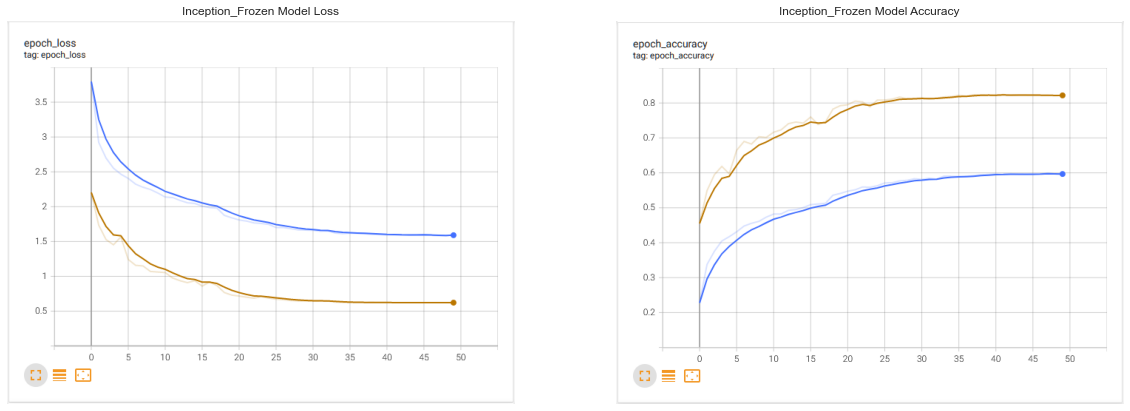

In [16]:
plt.figure(figsize = [20,15])
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread("data\models\\" + model_name + "\Loss.png", cv2.IMREAD_UNCHANGED))
plt.title(model_name + " Model Loss")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread("data\models\\" + model_name + "\Accuracy.png", cv2.IMREAD_UNCHANGED))
plt.title(model_name + " Model Accuracy")
plt.axis('off')
plt.show()

In [17]:
model2 = load_model("data/models/Inception_Frozen/0.6217-0.8210.h5")
eval_test = model2.evaluate(test_dataloader, verbose = 0)
mod2_test_loss = eval_test[0]
mod2_test_acc = eval_test[1]

In [18]:
print("InceptionNet Model with Convolution Base frozen test loss:", mod2_test_loss,
      "\nInceptionNet Model with Convolution Base frozen test accuracy:", mod2_test_acc)

InceptionNet Model with Convolution Base frozen test loss: 0.6430472135543823 
InceptionNet Model with Convolution Base frozen test accuracy: 0.8180000185966492


<a id="mod3"></a>
#### <center>InceptionNet Finetuned Model

[<div style="text-align: right"><font color="#000000">Back to Table of Content](#top)

To improve our Inception Network model's performance, we will fine-tune the whole Inception Network alongside the top-level classifier. We will load the weights from the previously trained frozen Convolution Base model and then re-train the model using very small weight updates.

In [7]:
tf.keras.backend.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)
tf.random.set_seed(0)

In [8]:
model_name = "Inception_Finetuned"
threshold = 0.9
stop_patience = 5
schedule_lr_patience = 3
schedule_lr_factor = 0.9
reduce_lr_patience = 2
reduce_lr_factor = 0.5
h = 128
w = 128
BATCH_SIZE = 32

In [9]:
preprocess_func = tf.keras.applications.inception_v3.preprocess_input

In [10]:
train_dataloader = data_generator(train_df, "Filepath", "Species", BATCH_SIZE, h, w, preprocess_func, is_train = True)
valid_dataloader = data_generator(valid_df, "Filepath", "Species", BATCH_SIZE, h, w, preprocess_func)
test_dataloader = data_generator(test_df, "Filepath", "Species", BATCH_SIZE, h, w, preprocess_func)

Found 58388 validated image filenames belonging to 400 classes.
Found 2000 validated image filenames belonging to 400 classes.
Found 2000 validated image filenames belonging to 400 classes.


In [11]:
inception_model = tf.keras.applications.inception_v3.InceptionV3(include_top = False, weights = 'imagenet',
                                                                 input_shape = (h, w, 3))

In [12]:
conv = Conv2D(1024, 2, kernel_initializer = HeUniform(seed = 3))(inception_model.layers[-1].output)
bn = BatchNormalization()(conv)
act = Activation("relu")(bn)
flat = Flatten()(act)
drop = Dropout(0.1)(flat)
output_layer = Dense(num_class, activation = "softmax", kernel_initializer = GlorotUniform(seed = 6))(drop)

model3 = Model(inputs = inception_model.inputs, outputs = output_layer, name = model_name)

In [13]:
try:
    os.mkdir("data/models/" + model_name)
except:
    ""
dot_img_file = 'data/models/' + model_name + '/Plot.png'
tf.keras.utils.plot_model(model3, to_file = dot_img_file, show_shapes = True)
model3.summary(show_trainable = True)

Model: "Inception_Finetuned"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               Y          
                                )]                                                                           
                                                                                                             
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                Y          
                                                                                                             
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 Y          
 alization)                                                                                

 conv2d_11 (Conv2D)             (None, 13, 13, 32)   6144        ['average_pooling2d[0][0]']      Y          
                                                                                                             
 batch_normalization_5 (BatchNo  (None, 13, 13, 64)  192         ['conv2d_5[0][0]']               Y          
 rmalization)                                                                                                
                                                                                                             
 batch_normalization_7 (BatchNo  (None, 13, 13, 64)  192         ['conv2d_7[0][0]']               Y          
 rmalization)                                                                                                
                                                                                                             
 batch_normalization_10 (BatchN  (None, 13, 13, 96)  288         ['conv2d_10[0][0]']              Y          
 ormalizat

                                                                                                             
 activation_12 (Activation)     (None, 13, 13, 64)   0           ['batch_normalization_12[0][0]'  Y          
                                                                 ]                                           
                                                                                                             
 activation_14 (Activation)     (None, 13, 13, 64)   0           ['batch_normalization_14[0][0]'  Y          
                                                                 ]                                           
                                                                                                             
 activation_17 (Activation)     (None, 13, 13, 96)   0           ['batch_normalization_17[0][0]'  Y          
                                                                 ]                                           
          

                                                                 ]                                           
                                                                                                             
 mixed2 (Concatenate)           (None, 13, 13, 288)  0           ['activation_19[0][0]',          Y          
                                                                  'activation_21[0][0]',                     
                                                                  'activation_24[0][0]',                     
                                                                  'activation_25[0][0]']                     
                                                                                                             
 conv2d_27 (Conv2D)             (None, 13, 13, 64)   18432       ['mixed2[0][0]']                 Y          
                                                                                                             
 batch_nor

                                                                 ]                                           
                                                                                                             
 conv2d_32 (Conv2D)             (None, 6, 6, 128)    114688      ['activation_31[0][0]']          Y          
                                                                                                             
 conv2d_37 (Conv2D)             (None, 6, 6, 128)    114688      ['activation_36[0][0]']          Y          
                                                                                                             
 batch_normalization_32 (BatchN  (None, 6, 6, 128)   384         ['conv2d_32[0][0]']              Y          
 ormalization)                                                                                               
                                                                                                             
 batch_nor

                                                                                                             
 conv2d_46 (Conv2D)             (None, 6, 6, 160)    179200      ['activation_45[0][0]']          Y          
                                                                                                             
 batch_normalization_41 (BatchN  (None, 6, 6, 160)   480         ['conv2d_41[0][0]']              Y          
 ormalization)                                                                                               
                                                                                                             
 batch_normalization_46 (BatchN  (None, 6, 6, 160)   480         ['conv2d_46[0][0]']              Y          
 ormalization)                                                                                               
                                                                                                             
 activatio

                                                                                                             
 activation_54 (Activation)     (None, 6, 6, 160)    0           ['batch_normalization_54[0][0]'  Y          
                                                                 ]                                           
                                                                                                             
 conv2d_55 (Conv2D)             (None, 6, 6, 160)    179200      ['activation_54[0][0]']          Y          
                                                                                                             
 batch_normalization_55 (BatchN  (None, 6, 6, 160)   480         ['conv2d_55[0][0]']              Y          
 ormalization)                                                                                               
                                                                                                             
 activatio

                                                                                                             
 activation_59 (Activation)     (None, 6, 6, 192)    0           ['batch_normalization_59[0][0]'  Y          
                                                                 ]                                           
                                                                                                             
 mixed6 (Concatenate)           (None, 6, 6, 768)    0           ['activation_50[0][0]',          Y          
                                                                  'activation_53[0][0]',                     
                                                                  'activation_58[0][0]',                     
                                                                  'activation_59[0][0]']                     
                                                                                                             
 conv2d_64

 ormalization)                                                                                               
                                                                                                             
 batch_normalization_69 (BatchN  (None, 6, 6, 192)   576         ['conv2d_69[0][0]']              Y          
 ormalization)                                                                                               
                                                                                                             
 activation_60 (Activation)     (None, 6, 6, 192)    0           ['batch_normalization_60[0][0]'  Y          
                                                                 ]                                           
                                                                                                             
 activation_63 (Activation)     (None, 6, 6, 192)    0           ['batch_normalization_63[0][0]'  Y          
          

                                                                                                             
 conv2d_80 (Conv2D)             (None, 2, 2, 448)    573440      ['mixed8[0][0]']                 Y          
                                                                                                             
 batch_normalization_80 (BatchN  (None, 2, 2, 448)   1344        ['conv2d_80[0][0]']              Y          
 ormalization)                                                                                               
                                                                                                             
 activation_80 (Activation)     (None, 2, 2, 448)    0           ['batch_normalization_80[0][0]'  Y          
                                                                 ]                                           
                                                                                                             
 conv2d_77

                                                                                                             
 concatenate (Concatenate)      (None, 2, 2, 768)    0           ['activation_82[0][0]',          Y          
                                                                  'activation_83[0][0]']                     
                                                                                                             
 activation_84 (Activation)     (None, 2, 2, 192)    0           ['batch_normalization_84[0][0]'  Y          
                                                                 ]                                           
                                                                                                             
 mixed9 (Concatenate)           (None, 2, 2, 2048)   0           ['activation_76[0][0]',          Y          
                                                                  'mixed9_0[0][0]',                          
          

 activation_92 (Activation)     (None, 2, 2, 384)    0           ['batch_normalization_92[0][0]'  Y          
                                                                 ]                                           
                                                                                                             
 batch_normalization_93 (BatchN  (None, 2, 2, 192)   576         ['conv2d_93[0][0]']              Y          
 ormalization)                                                                                               
                                                                                                             
 activation_85 (Activation)     (None, 2, 2, 320)    0           ['batch_normalization_85[0][0]'  Y          
                                                                 ]                                           
                                                                                                             
 mixed9_1 

In [14]:
optimizer = Adam(0.0001)
callback_lst = callbacks(model_name, threshold, stop_patience, schedule_lr_patience, schedule_lr_factor, reduce_lr_patience,
                         reduce_lr_factor)
model3.compile(optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [15]:
model3.load_weights("data/models/Inception_Frozen/0.6217-0.8210.h5")

In [16]:
%%time
model3.fit(train_dataloader, steps_per_epoch = len(train_dataloader), epochs = 50, validation_data = valid_dataloader,
           callbacks = callback_lst)

Epoch 1/50
1825/1825 [==============================] - 453s 243ms/step - loss: 2.3272 - accuracy: 0.4483 - val_loss: 0.8906 - val_accuracy: 0.7435 - lr: 1.0000e-04 - next_lr: 1.0000e-04 - best_val_accuracy: 0.7435 - best_val_loss: 0.8906 - best_epoch: 1.0000
Epoch 2/50
1825/1825 [==============================] - 439s 241ms/step - loss: 1.5303 - accuracy: 0.6053 - val_loss: 0.6323 - val_accuracy: 0.8255 - lr: 1.0000e-04 - next_lr: 1.0000e-04 - best_val_accuracy: 0.8255 - best_val_loss: 0.6323 - best_epoch: 2.0000
Epoch 3/50
1825/1825 [==============================] - 440s 241ms/step - loss: 1.2719 - accuracy: 0.6652 - val_loss: 0.5731 - val_accuracy: 0.8340 - lr: 1.0000e-04 - next_lr: 9.0000e-05 - best_val_accuracy: 0.8340 - best_val_loss: 0.5731 - best_epoch: 3.0000
Epoch 4/50
1825/1825 [==============================] - 440s 241ms/step - loss: 1.0934 - accuracy: 0.7066 - val_loss: 0.4897 - val_accuracy: 0.8515 - lr: 9.0000e-05 - next_lr: 9.0000e-05 - best_val_accuracy: 0.8515 - bes

Epoch 31/50
1825/1825 [==============================] - 438s 240ms/step - loss: 0.2656 - accuracy: 0.9222 - val_loss: 0.1849 - val_accuracy: 0.9450 - lr: 6.8101e-08 - next_lr: 3.4051e-08 - best_val_accuracy: 0.9495 - best_val_loss: 0.1802 - best_epoch: 22.0000
Epoch 32/50
1825/1825 [==============================] - ETA: 0s - loss: 0.2690 - accuracy: 0.9195
Validation Loss hasn't decreased for last 5 epochs. Do you want to stop training? Y/N
y
Training has been terminated after 32 epochs.
1825/1825 [==============================] - 443s 242ms/step - loss: 0.2690 - accuracy: 0.9195 - val_loss: 0.1810 - val_accuracy: 0.9465 - lr: 3.4051e-08 - next_lr: 1.7025e-08 - best_val_accuracy: 0.9495 - best_val_loss: 0.1802 - best_epoch: 22.0000
CPU times: total: 7h 52min 54s
Wall time: 10h 18min 16s


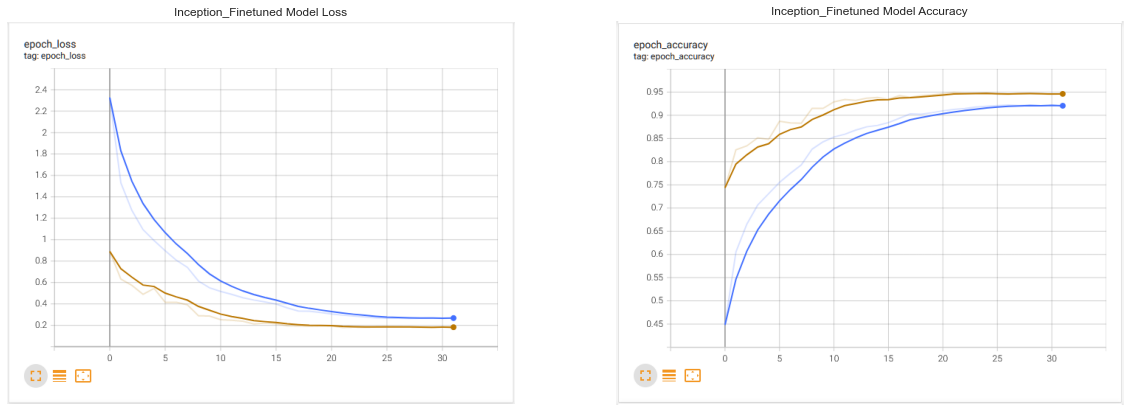

In [17]:
plt.figure(figsize = [20,15])
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread("data\models\\" + model_name + "\Loss.png", cv2.IMREAD_UNCHANGED))
plt.title(model_name + " Model Loss")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread("data\models\\" + model_name + "\Accuracy.png", cv2.IMREAD_UNCHANGED))
plt.title(model_name + " Model Accuracy")
plt.axis('off')
plt.show()

In [18]:
model3 = load_model("data/models/Inception_Finetuned/0.1802-0.9495.h5")
eval_test = model3.evaluate(test_dataloader, verbose = 0)
mod3_test_loss = eval_test[0]
mod3_test_acc = eval_test[1]

In [19]:
print("Finetuned InceptionNet Model test loss:", mod3_test_loss,
      "\nFinetuned InceptionNet Model test accuracy:", mod3_test_acc)

Finetuned InceptionNet Model test loss: 0.12416183948516846 
Finetuned InceptionNet Model test accuracy: 0.9670000076293945


<a id="mod4"></a>
#### <center>DenseNet Frozen Model

[<div style="text-align: right"><font color="#000000">Back to Table of Content](#top)

Similar to Inception Network, we will also use DenseNet for transfer learning. We will use our own classifier on top of convolution base of the DenseNet with imagenet weights loaded. In this model, we will freeze the DenseNet and train only the top classifier. We will use images resized to height of 128 and width of 128 for this model.

In [7]:
tf.keras.backend.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)
tf.random.set_seed(0)

In [8]:
model_name = "DenseNet_Frozen"
threshold = 0.92
stop_patience = 5
schedule_lr_patience = 3
schedule_lr_factor = 0.9
reduce_lr_patience = 2
reduce_lr_factor = 0.5
h = 128
w = 128
BATCH_SIZE = 256

In [9]:
preprocess_func = tf.keras.applications.densenet.preprocess_input

In [10]:
train_dataloader = data_generator(train_df, "Filepath", "Species", BATCH_SIZE, h, w, preprocess_func, is_train = True)
valid_dataloader = data_generator(valid_df, "Filepath", "Species", BATCH_SIZE, h, w, preprocess_func)
test_dataloader = data_generator(test_df, "Filepath", "Species", BATCH_SIZE, h, w, preprocess_func)

Found 58388 validated image filenames belonging to 400 classes.
Found 2000 validated image filenames belonging to 400 classes.
Found 2000 validated image filenames belonging to 400 classes.


In [11]:
den201_model = tf.keras.applications.densenet.DenseNet201(include_top = False, weights = 'imagenet', input_shape = (h, w, 3))
for layer in den201_model.layers:
    layer.trainable = False

In [12]:
pool = AveragePooling2D(pool_size = (2, 2))(den201_model.layers[-1].output)
conv = Conv2D(1024, 2, kernel_initializer = HeUniform(seed = 3))(pool)
bn = BatchNormalization()(conv)
act = Activation("relu")(bn)
flat = Flatten()(act)
drop = Dropout(0.1)(flat)
output_layer = Dense(num_class, activation = "softmax", kernel_initializer = GlorotUniform(seed = 6))(drop)

model4 = Model(inputs = den201_model.inputs, outputs = output_layer, name = model_name)

In [13]:
try:
    os.mkdir("data/models/" + model_name)
except:
    ""
dot_img_file = 'data/models/' + model_name + '/Plot.png'
tf.keras.utils.plot_model(model4, to_file = dot_img_file, show_shapes = True)
model4.summary(show_trainable = True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.414882 to fit

Model: "DenseNet_Frozen"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               N          
                                )]                                                                           
                                                                                                             
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                N          
                                                                                                             
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         N          
               

 te)                                                              'conv2_block3_2_conv[0][0]']               
                                                                                                             
 conv2_block4_0_bn (BatchNormal  (None, 32, 32, 160)  640        ['conv2_block3_concat[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 conv2_block4_0_relu (Activatio  (None, 32, 32, 160)  0          ['conv2_block4_0_bn[0][0]']      N          
 n)                                                                                                          
                                                                                                             
 conv2_block4_1_conv (Conv2D)   (None, 32, 32, 128)  20480       ['conv2_block4_0_relu[0][0]']    N          
          

 conv3_block1_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block1_1_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 conv3_block1_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block1_1_bn[0][0]']      N          
 n)                                                                                                          
                                                                                                             
 conv3_block1_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block1_1_relu[0][0]']    N          
                                                                                                             
 conv3_block1_concat (Concatena  (None, 16, 16, 160)  0          ['pool2_pool[0][0]',             N          
 te)      

                                                                                                             
 conv3_block5_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block5_1_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 conv3_block5_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block5_1_bn[0][0]']      N          
 n)                                                                                                          
                                                                                                             
 conv3_block5_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block5_1_relu[0][0]']    N          
                                                                                                             
 conv3_blo

 conv3_block9_1_conv (Conv2D)   (None, 16, 16, 128)  49152       ['conv3_block9_0_relu[0][0]']    N          
                                                                                                             
 conv3_block9_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block9_1_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 conv3_block9_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block9_1_bn[0][0]']      N          
 n)                                                                                                          
                                                                                                             
 conv3_block9_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block9_1_relu[0][0]']    N          
          

                                                                                                             
 pool3_pool (AveragePooling2D)  (None, 8, 8, 256)    0           ['pool3_conv[0][0]']             N          
                                                                                                             
 conv4_block1_0_bn (BatchNormal  (None, 8, 8, 256)   1024        ['pool3_pool[0][0]']             N          
 ization)                                                                                                    
                                                                                                             
 conv4_block1_0_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block1_0_bn[0][0]']      N          
 n)                                                                                                          
                                                                                                             
 conv4_blo

                                                                                                             
 conv4_block4_concat (Concatena  (None, 8, 8, 384)   0           ['conv4_block3_concat[0][0]',    N          
 te)                                                              'conv4_block4_2_conv[0][0]']               
                                                                                                             
 conv4_block5_0_bn (BatchNormal  (None, 8, 8, 384)   1536        ['conv4_block4_concat[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 conv4_block5_0_relu (Activatio  (None, 8, 8, 384)   0           ['conv4_block5_0_bn[0][0]']      N          
 n)                                                                                                          
          

 conv4_block8_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv4_block8_1_relu[0][0]']    N          
                                                                                                             
 conv4_block8_concat (Concatena  (None, 8, 8, 512)   0           ['conv4_block7_concat[0][0]',    N          
 te)                                                              'conv4_block8_2_conv[0][0]']               
                                                                                                             
 conv4_block9_0_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv4_block8_concat[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 conv4_block9_0_relu (Activatio  (None, 8, 8, 512)   0           ['conv4_block9_0_bn[0][0]']      N          
 n)       

                                                                                                             
 conv4_block12_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block12_1_relu[0][0]']   N          
                                                                                                             
 conv4_block12_concat (Concaten  (None, 8, 8, 640)   0           ['conv4_block11_concat[0][0]',   N          
 ate)                                                             'conv4_block12_2_conv[0][0]']              
                                                                                                             
 conv4_block13_0_bn (BatchNorma  (None, 8, 8, 640)   2560        ['conv4_block12_concat[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 conv4_blo

 on)                                                                                                         
                                                                                                             
 conv4_block16_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block16_1_relu[0][0]']   N          
                                                                                                             
 conv4_block16_concat (Concaten  (None, 8, 8, 768)   0           ['conv4_block15_concat[0][0]',   N          
 ate)                                                             'conv4_block16_2_conv[0][0]']              
                                                                                                             
 conv4_block17_0_bn (BatchNorma  (None, 8, 8, 768)   3072        ['conv4_block16_concat[0][0]']   N          
 lization)                                                                                                   
          

 conv4_block20_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block20_1_bn[0][0]']     N          
 on)                                                                                                         
                                                                                                             
 conv4_block20_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block20_1_relu[0][0]']   N          
                                                                                                             
 conv4_block20_concat (Concaten  (None, 8, 8, 896)   0           ['conv4_block19_concat[0][0]',   N          
 ate)                                                             'conv4_block20_2_conv[0][0]']              
                                                                                                             
 conv4_block21_0_bn (BatchNorma  (None, 8, 8, 896)   3584        ['conv4_block20_concat[0][0]']   N          
 lization)

                                                                                                             
 conv4_block24_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block24_1_bn[0][0]']     N          
 on)                                                                                                         
                                                                                                             
 conv4_block24_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block24_1_relu[0][0]']   N          
                                                                                                             
 conv4_block24_concat (Concaten  (None, 8, 8, 1024)  0           ['conv4_block23_concat[0][0]',   N          
 ate)                                                             'conv4_block24_2_conv[0][0]']              
                                                                                                             
 conv4_blo

 lization)                                                                                                   
                                                                                                             
 conv4_block28_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block28_1_bn[0][0]']     N          
 on)                                                                                                         
                                                                                                             
 conv4_block28_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block28_1_relu[0][0]']   N          
                                                                                                             
 conv4_block28_concat (Concaten  (None, 8, 8, 1152)  0           ['conv4_block27_concat[0][0]',   N          
 ate)                                                             'conv4_block28_2_conv[0][0]']              
          

 conv4_block32_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block32_1_conv[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 conv4_block32_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block32_1_bn[0][0]']     N          
 on)                                                                                                         
                                                                                                             
 conv4_block32_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block32_1_relu[0][0]']   N          
                                                                                                             
 conv4_block32_concat (Concaten  (None, 8, 8, 1280)  0           ['conv4_block31_concat[0][0]',   N          
 ate)     

                                                                                                             
 conv4_block36_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block36_1_conv[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 conv4_block36_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block36_1_bn[0][0]']     N          
 on)                                                                                                         
                                                                                                             
 conv4_block36_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block36_1_relu[0][0]']   N          
                                                                                                             
 conv4_blo

 conv4_block40_1_conv (Conv2D)  (None, 8, 8, 128)    192512      ['conv4_block40_0_relu[0][0]']   N          
                                                                                                             
 conv4_block40_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block40_1_conv[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 conv4_block40_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block40_1_bn[0][0]']     N          
 on)                                                                                                         
                                                                                                             
 conv4_block40_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block40_1_relu[0][0]']   N          
          

                                                                                                             
 conv4_block44_1_conv (Conv2D)  (None, 8, 8, 128)    208896      ['conv4_block44_0_relu[0][0]']   N          
                                                                                                             
 conv4_block44_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block44_1_conv[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 conv4_block44_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block44_1_bn[0][0]']     N          
 on)                                                                                                         
                                                                                                             
 conv4_blo

 on)                                                                                                         
                                                                                                             
 conv4_block48_1_conv (Conv2D)  (None, 8, 8, 128)    225280      ['conv4_block48_0_relu[0][0]']   N          
                                                                                                             
 conv4_block48_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block48_1_conv[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 conv4_block48_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block48_1_bn[0][0]']     N          
 on)                                                                                                         
          

 conv5_block3_2_conv (Conv2D)   (None, 4, 4, 32)     36864       ['conv5_block3_1_relu[0][0]']    N          
                                                                                                             
 conv5_block3_concat (Concatena  (None, 4, 4, 992)   0           ['conv5_block2_concat[0][0]',    N          
 te)                                                              'conv5_block3_2_conv[0][0]']               
                                                                                                             
 conv5_block4_0_bn (BatchNormal  (None, 4, 4, 992)   3968        ['conv5_block3_concat[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 conv5_block4_0_relu (Activatio  (None, 4, 4, 992)   0           ['conv5_block4_0_bn[0][0]']      N          
 n)       

                                                                                                             
 conv5_block7_2_conv (Conv2D)   (None, 4, 4, 32)     36864       ['conv5_block7_1_relu[0][0]']    N          
                                                                                                             
 conv5_block7_concat (Concatena  (None, 4, 4, 1120)  0           ['conv5_block6_concat[0][0]',    N          
 te)                                                              'conv5_block7_2_conv[0][0]']               
                                                                                                             
 conv5_block8_0_bn (BatchNormal  (None, 4, 4, 1120)  4480        ['conv5_block7_concat[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 conv5_blo

 on)                                                                                                         
                                                                                                             
 conv5_block11_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block11_1_relu[0][0]']   N          
                                                                                                             
 conv5_block11_concat (Concaten  (None, 4, 4, 1248)  0           ['conv5_block10_concat[0][0]',   N          
 ate)                                                             'conv5_block11_2_conv[0][0]']              
                                                                                                             
 conv5_block12_0_bn (BatchNorma  (None, 4, 4, 1248)  4992        ['conv5_block11_concat[0][0]']   N          
 lization)                                                                                                   
          

 conv5_block15_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block15_1_bn[0][0]']     N          
 on)                                                                                                         
                                                                                                             
 conv5_block15_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block15_1_relu[0][0]']   N          
                                                                                                             
 conv5_block15_concat (Concaten  (None, 4, 4, 1376)  0           ['conv5_block14_concat[0][0]',   N          
 ate)                                                             'conv5_block15_2_conv[0][0]']              
                                                                                                             
 conv5_block16_0_bn (BatchNorma  (None, 4, 4, 1376)  5504        ['conv5_block15_concat[0][0]']   N          
 lization)

                                                                                                             
 conv5_block19_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block19_1_bn[0][0]']     N          
 on)                                                                                                         
                                                                                                             
 conv5_block19_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block19_1_relu[0][0]']   N          
                                                                                                             
 conv5_block19_concat (Concaten  (None, 4, 4, 1504)  0           ['conv5_block18_concat[0][0]',   N          
 ate)                                                             'conv5_block19_2_conv[0][0]']              
                                                                                                             
 conv5_blo

 lization)                                                                                                   
                                                                                                             
 conv5_block23_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block23_1_bn[0][0]']     N          
 on)                                                                                                         
                                                                                                             
 conv5_block23_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block23_1_relu[0][0]']   N          
                                                                                                             
 conv5_block23_concat (Concaten  (None, 4, 4, 1632)  0           ['conv5_block22_concat[0][0]',   N          
 ate)                                                             'conv5_block23_2_conv[0][0]']              
          

 conv5_block27_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block27_1_conv[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 conv5_block27_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block27_1_bn[0][0]']     N          
 on)                                                                                                         
                                                                                                             
 conv5_block27_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block27_1_relu[0][0]']   N          
                                                                                                             
 conv5_block27_concat (Concaten  (None, 4, 4, 1760)  0           ['conv5_block26_concat[0][0]',   N          
 ate)     

                                                                                                             
 conv5_block31_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block31_1_conv[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 conv5_block31_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block31_1_bn[0][0]']     N          
 on)                                                                                                         
                                                                                                             
 conv5_block31_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block31_1_relu[0][0]']   N          
                                                                                                             
 conv5_blo

In [14]:
optimizer = Adam(0.01)
callback_lst = callbacks(model_name, threshold, stop_patience, schedule_lr_patience, schedule_lr_factor, reduce_lr_patience,
                         reduce_lr_factor)
model4.compile(optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [15]:
%%time
model4.fit(train_dataloader, steps_per_epoch = len(train_dataloader), epochs = 50, validation_data = valid_dataloader,
           callbacks = callback_lst)

Epoch 1/50
229/229 [==============================] - 413s 2s/step - loss: 2.2396 - accuracy: 0.4950 - val_loss: 0.6644 - val_accuracy: 0.8105 - lr: 0.0100 - next_lr: 0.0100 - best_val_accuracy: 0.8105 - best_val_loss: 0.6644 - best_epoch: 1.0000
Epoch 2/50
229/229 [==============================] - 387s 2s/step - loss: 1.3174 - accuracy: 0.6596 - val_loss: 0.4454 - val_accuracy: 0.8680 - lr: 0.0100 - next_lr: 0.0100 - best_val_accuracy: 0.8680 - best_val_loss: 0.4454 - best_epoch: 2.0000
Epoch 3/50
229/229 [==============================] - 388s 2s/step - loss: 1.1161 - accuracy: 0.7058 - val_loss: 0.4379 - val_accuracy: 0.8715 - lr: 0.0100 - next_lr: 0.0090 - best_val_accuracy: 0.8715 - best_val_loss: 0.4379 - best_epoch: 3.0000
Epoch 4/50
229/229 [==============================] - 386s 2s/step - loss: 0.9866 - accuracy: 0.7345 - val_loss: 0.3912 - val_accuracy: 0.8845 - lr: 0.0090 - next_lr: 0.0090 - best_val_accuracy: 0.8845 - best_val_loss: 0.3912 - best_epoch: 4.0000
Epoch 5/50
2

Epoch 34/50
229/229 [==============================] - 386s 2s/step - loss: 0.2801 - accuracy: 0.9157 - val_loss: 0.1924 - val_accuracy: 0.9525 - lr: 1.9613e-04 - next_lr: 1.9613e-04 - best_val_accuracy: 0.9525 - best_val_loss: 0.1924 - best_epoch: 34.0000
Epoch 35/50
229/229 [==============================] - 385s 2s/step - loss: 0.2747 - accuracy: 0.9162 - val_loss: 0.1927 - val_accuracy: 0.9500 - lr: 1.9613e-04 - next_lr: 1.9613e-04 - best_val_accuracy: 0.9525 - best_val_loss: 0.1924 - best_epoch: 34.0000
Epoch 36/50
229/229 [==============================] - 388s 2s/step - loss: 0.2752 - accuracy: 0.9165 - val_loss: 0.1921 - val_accuracy: 0.9500 - lr: 1.9613e-04 - next_lr: 1.7652e-04 - best_val_accuracy: 0.9525 - best_val_loss: 0.1921 - best_epoch: 36.0000
Epoch 37/50
229/229 [==============================] - 385s 2s/step - loss: 0.2817 - accuracy: 0.9139 - val_loss: 0.1897 - val_accuracy: 0.9510 - lr: 1.7652e-04 - next_lr: 1.7652e-04 - best_val_accuracy: 0.9525 - best_val_loss: 0

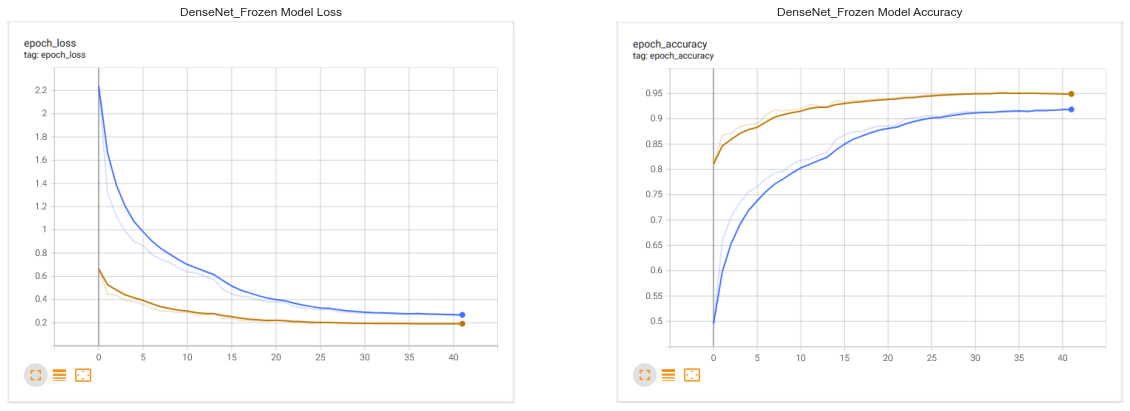

In [16]:
plt.figure(figsize = [20,15])
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread("data\models\\" + model_name + "\Loss.png", cv2.IMREAD_UNCHANGED))
plt.title(model_name + " Model Loss")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread("data\models\\" + model_name + "\Accuracy.png", cv2.IMREAD_UNCHANGED))
plt.title(model_name + " Model Accuracy")
plt.axis('off')
plt.show()

In [17]:
model4 = load_model("data/models/DenseNet_Frozen/0.1897-0.9510.h5")
eval_test = model4.evaluate(test_dataloader, verbose = 0)
mod4_test_loss = eval_test[0]
mod4_test_acc = eval_test[1]

In [18]:
print("DenseNet Model with Convolution Base frozen test loss:", mod4_test_loss,
      "\nDenseNet Model with Convolution Base frozen test accuracy:", mod4_test_acc)

DenseNet Model with Convolution Base frozen test loss: 0.1348697543144226 
DenseNet Model with Convolution Base frozen test accuracy: 0.9574999809265137


<a id="mod5"></a>
#### <center>DenseNet Finetuned Model

[<div style="text-align: right"><font color="#000000">Back to Table of Content](#top)

To improve our DenseNet model's performance, we will fine-tune the Convolution 5 of the DenseNet alongside the top-level classifier. We will load the weights from the previously trained DenseNet model with frozen Convolution Base and then re-train the model using very small weight updates.

In [7]:
tf.keras.backend.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)
tf.random.set_seed(0)

In [8]:
model_name = "DenseNet_Finetuned"
threshold = 0.94
stop_patience = 5
schedule_lr_patience = 3
schedule_lr_factor = 0.9
reduce_lr_patience = 2
reduce_lr_factor = 0.5
h = 128
w = 128
BATCH_SIZE = 32

In [9]:
preprocess_func = tf.keras.applications.densenet.preprocess_input

In [10]:
train_dataloader = data_generator(train_df, "Filepath", "Species", BATCH_SIZE, h, w, preprocess_func, is_train = True)
valid_dataloader = data_generator(valid_df, "Filepath", "Species", BATCH_SIZE, h, w, preprocess_func)
test_dataloader = data_generator(test_df, "Filepath", "Species", BATCH_SIZE, h, w, preprocess_func)

Found 58388 validated image filenames belonging to 400 classes.
Found 2000 validated image filenames belonging to 400 classes.
Found 2000 validated image filenames belonging to 400 classes.


In [11]:
den201_model = tf.keras.applications.densenet.DenseNet201(include_top = False, weights = 'imagenet', input_shape = (h, w, 3))
for layer in den201_model.layers[:-226]:
    layer.trainable = False

In [12]:
pool = AveragePooling2D(pool_size = (2, 2))(den201_model.layers[-1].output)
conv = Conv2D(1024, 2, kernel_initializer = HeUniform(seed = 3))(pool)
bn = BatchNormalization()(conv)
act = Activation("relu")(bn)
flat = Flatten()(act)
drop = Dropout(0.1)(flat)
output_layer = Dense(num_class, activation = "softmax", kernel_initializer = GlorotUniform(seed = 6))(drop)

model5 = Model(inputs = den201_model.inputs, outputs = output_layer, name = model_name)

In [13]:
model5.load_weights("data/models/DenseNet_Frozen/0.1897-0.9510.h5")

In [14]:
try:
    os.mkdir("data/models/" + model_name)
except:
    ""
dot_img_file = 'data/models/' + model_name + '/Plot.png'
tf.keras.utils.plot_model(model5, to_file = dot_img_file, show_shapes = True)
model5.summary(show_trainable = True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.414882 to fit

Model: "DenseNet_Finetuned"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               N          
                                )]                                                                           
                                                                                                             
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                N          
                                                                                                             
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         N          
            

 te)                                                              'conv2_block3_2_conv[0][0]']               
                                                                                                             
 conv2_block4_0_bn (BatchNormal  (None, 32, 32, 160)  640        ['conv2_block3_concat[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 conv2_block4_0_relu (Activatio  (None, 32, 32, 160)  0          ['conv2_block4_0_bn[0][0]']      N          
 n)                                                                                                          
                                                                                                             
 conv2_block4_1_conv (Conv2D)   (None, 32, 32, 128)  20480       ['conv2_block4_0_relu[0][0]']    N          
          

 conv3_block1_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block1_1_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 conv3_block1_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block1_1_bn[0][0]']      N          
 n)                                                                                                          
                                                                                                             
 conv3_block1_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block1_1_relu[0][0]']    N          
                                                                                                             
 conv3_block1_concat (Concatena  (None, 16, 16, 160)  0          ['pool2_pool[0][0]',             N          
 te)      

                                                                                                             
 conv3_block5_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block5_1_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 conv3_block5_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block5_1_bn[0][0]']      N          
 n)                                                                                                          
                                                                                                             
 conv3_block5_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block5_1_relu[0][0]']    N          
                                                                                                             
 conv3_blo

 conv3_block9_1_conv (Conv2D)   (None, 16, 16, 128)  49152       ['conv3_block9_0_relu[0][0]']    N          
                                                                                                             
 conv3_block9_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block9_1_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 conv3_block9_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block9_1_bn[0][0]']      N          
 n)                                                                                                          
                                                                                                             
 conv3_block9_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block9_1_relu[0][0]']    N          
          

                                                                                                             
 pool3_pool (AveragePooling2D)  (None, 8, 8, 256)    0           ['pool3_conv[0][0]']             N          
                                                                                                             
 conv4_block1_0_bn (BatchNormal  (None, 8, 8, 256)   1024        ['pool3_pool[0][0]']             N          
 ization)                                                                                                    
                                                                                                             
 conv4_block1_0_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block1_0_bn[0][0]']      N          
 n)                                                                                                          
                                                                                                             
 conv4_blo

                                                                                                             
 conv4_block4_concat (Concatena  (None, 8, 8, 384)   0           ['conv4_block3_concat[0][0]',    N          
 te)                                                              'conv4_block4_2_conv[0][0]']               
                                                                                                             
 conv4_block5_0_bn (BatchNormal  (None, 8, 8, 384)   1536        ['conv4_block4_concat[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 conv4_block5_0_relu (Activatio  (None, 8, 8, 384)   0           ['conv4_block5_0_bn[0][0]']      N          
 n)                                                                                                          
          

 conv4_block8_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv4_block8_1_relu[0][0]']    N          
                                                                                                             
 conv4_block8_concat (Concatena  (None, 8, 8, 512)   0           ['conv4_block7_concat[0][0]',    N          
 te)                                                              'conv4_block8_2_conv[0][0]']               
                                                                                                             
 conv4_block9_0_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv4_block8_concat[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 conv4_block9_0_relu (Activatio  (None, 8, 8, 512)   0           ['conv4_block9_0_bn[0][0]']      N          
 n)       

                                                                                                             
 conv4_block12_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block12_1_relu[0][0]']   N          
                                                                                                             
 conv4_block12_concat (Concaten  (None, 8, 8, 640)   0           ['conv4_block11_concat[0][0]',   N          
 ate)                                                             'conv4_block12_2_conv[0][0]']              
                                                                                                             
 conv4_block13_0_bn (BatchNorma  (None, 8, 8, 640)   2560        ['conv4_block12_concat[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 conv4_blo

 on)                                                                                                         
                                                                                                             
 conv4_block16_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block16_1_relu[0][0]']   N          
                                                                                                             
 conv4_block16_concat (Concaten  (None, 8, 8, 768)   0           ['conv4_block15_concat[0][0]',   N          
 ate)                                                             'conv4_block16_2_conv[0][0]']              
                                                                                                             
 conv4_block17_0_bn (BatchNorma  (None, 8, 8, 768)   3072        ['conv4_block16_concat[0][0]']   N          
 lization)                                                                                                   
          

 conv4_block20_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block20_1_bn[0][0]']     N          
 on)                                                                                                         
                                                                                                             
 conv4_block20_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block20_1_relu[0][0]']   N          
                                                                                                             
 conv4_block20_concat (Concaten  (None, 8, 8, 896)   0           ['conv4_block19_concat[0][0]',   N          
 ate)                                                             'conv4_block20_2_conv[0][0]']              
                                                                                                             
 conv4_block21_0_bn (BatchNorma  (None, 8, 8, 896)   3584        ['conv4_block20_concat[0][0]']   N          
 lization)

                                                                                                             
 conv4_block24_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block24_1_bn[0][0]']     N          
 on)                                                                                                         
                                                                                                             
 conv4_block24_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block24_1_relu[0][0]']   N          
                                                                                                             
 conv4_block24_concat (Concaten  (None, 8, 8, 1024)  0           ['conv4_block23_concat[0][0]',   N          
 ate)                                                             'conv4_block24_2_conv[0][0]']              
                                                                                                             
 conv4_blo

 lization)                                                                                                   
                                                                                                             
 conv4_block28_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block28_1_bn[0][0]']     N          
 on)                                                                                                         
                                                                                                             
 conv4_block28_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block28_1_relu[0][0]']   N          
                                                                                                             
 conv4_block28_concat (Concaten  (None, 8, 8, 1152)  0           ['conv4_block27_concat[0][0]',   N          
 ate)                                                             'conv4_block28_2_conv[0][0]']              
          

 conv4_block32_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block32_1_conv[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 conv4_block32_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block32_1_bn[0][0]']     N          
 on)                                                                                                         
                                                                                                             
 conv4_block32_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block32_1_relu[0][0]']   N          
                                                                                                             
 conv4_block32_concat (Concaten  (None, 8, 8, 1280)  0           ['conv4_block31_concat[0][0]',   N          
 ate)     

                                                                                                             
 conv4_block36_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block36_1_conv[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 conv4_block36_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block36_1_bn[0][0]']     N          
 on)                                                                                                         
                                                                                                             
 conv4_block36_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block36_1_relu[0][0]']   N          
                                                                                                             
 conv4_blo

 conv4_block40_1_conv (Conv2D)  (None, 8, 8, 128)    192512      ['conv4_block40_0_relu[0][0]']   N          
                                                                                                             
 conv4_block40_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block40_1_conv[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 conv4_block40_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block40_1_bn[0][0]']     N          
 on)                                                                                                         
                                                                                                             
 conv4_block40_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block40_1_relu[0][0]']   N          
          

                                                                                                             
 conv4_block44_1_conv (Conv2D)  (None, 8, 8, 128)    208896      ['conv4_block44_0_relu[0][0]']   N          
                                                                                                             
 conv4_block44_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block44_1_conv[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 conv4_block44_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block44_1_bn[0][0]']     N          
 on)                                                                                                         
                                                                                                             
 conv4_blo

 on)                                                                                                         
                                                                                                             
 conv4_block48_1_conv (Conv2D)  (None, 8, 8, 128)    225280      ['conv4_block48_0_relu[0][0]']   N          
                                                                                                             
 conv4_block48_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block48_1_conv[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 conv4_block48_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block48_1_bn[0][0]']     N          
 on)                                                                                                         
          

 conv5_block3_2_conv (Conv2D)   (None, 4, 4, 32)     36864       ['conv5_block3_1_relu[0][0]']    Y          
                                                                                                             
 conv5_block3_concat (Concatena  (None, 4, 4, 992)   0           ['conv5_block2_concat[0][0]',    Y          
 te)                                                              'conv5_block3_2_conv[0][0]']               
                                                                                                             
 conv5_block4_0_bn (BatchNormal  (None, 4, 4, 992)   3968        ['conv5_block3_concat[0][0]']    Y          
 ization)                                                                                                    
                                                                                                             
 conv5_block4_0_relu (Activatio  (None, 4, 4, 992)   0           ['conv5_block4_0_bn[0][0]']      Y          
 n)       

                                                                                                             
 conv5_block7_2_conv (Conv2D)   (None, 4, 4, 32)     36864       ['conv5_block7_1_relu[0][0]']    Y          
                                                                                                             
 conv5_block7_concat (Concatena  (None, 4, 4, 1120)  0           ['conv5_block6_concat[0][0]',    Y          
 te)                                                              'conv5_block7_2_conv[0][0]']               
                                                                                                             
 conv5_block8_0_bn (BatchNormal  (None, 4, 4, 1120)  4480        ['conv5_block7_concat[0][0]']    Y          
 ization)                                                                                                    
                                                                                                             
 conv5_blo

 on)                                                                                                         
                                                                                                             
 conv5_block11_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block11_1_relu[0][0]']   Y          
                                                                                                             
 conv5_block11_concat (Concaten  (None, 4, 4, 1248)  0           ['conv5_block10_concat[0][0]',   Y          
 ate)                                                             'conv5_block11_2_conv[0][0]']              
                                                                                                             
 conv5_block12_0_bn (BatchNorma  (None, 4, 4, 1248)  4992        ['conv5_block11_concat[0][0]']   Y          
 lization)                                                                                                   
          

 conv5_block15_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block15_1_bn[0][0]']     Y          
 on)                                                                                                         
                                                                                                             
 conv5_block15_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block15_1_relu[0][0]']   Y          
                                                                                                             
 conv5_block15_concat (Concaten  (None, 4, 4, 1376)  0           ['conv5_block14_concat[0][0]',   Y          
 ate)                                                             'conv5_block15_2_conv[0][0]']              
                                                                                                             
 conv5_block16_0_bn (BatchNorma  (None, 4, 4, 1376)  5504        ['conv5_block15_concat[0][0]']   Y          
 lization)

                                                                                                             
 conv5_block19_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block19_1_bn[0][0]']     Y          
 on)                                                                                                         
                                                                                                             
 conv5_block19_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block19_1_relu[0][0]']   Y          
                                                                                                             
 conv5_block19_concat (Concaten  (None, 4, 4, 1504)  0           ['conv5_block18_concat[0][0]',   Y          
 ate)                                                             'conv5_block19_2_conv[0][0]']              
                                                                                                             
 conv5_blo

 lization)                                                                                                   
                                                                                                             
 conv5_block23_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block23_1_bn[0][0]']     Y          
 on)                                                                                                         
                                                                                                             
 conv5_block23_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block23_1_relu[0][0]']   Y          
                                                                                                             
 conv5_block23_concat (Concaten  (None, 4, 4, 1632)  0           ['conv5_block22_concat[0][0]',   Y          
 ate)                                                             'conv5_block23_2_conv[0][0]']              
          

 conv5_block27_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block27_1_conv[0][0]']   Y          
 lization)                                                                                                   
                                                                                                             
 conv5_block27_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block27_1_bn[0][0]']     Y          
 on)                                                                                                         
                                                                                                             
 conv5_block27_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block27_1_relu[0][0]']   Y          
                                                                                                             
 conv5_block27_concat (Concaten  (None, 4, 4, 1760)  0           ['conv5_block26_concat[0][0]',   Y          
 ate)     

                                                                                                             
 conv5_block31_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block31_1_conv[0][0]']   Y          
 lization)                                                                                                   
                                                                                                             
 conv5_block31_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block31_1_bn[0][0]']     Y          
 on)                                                                                                         
                                                                                                             
 conv5_block31_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block31_1_relu[0][0]']   Y          
                                                                                                             
 conv5_blo

In [15]:
optimizer = Adam(0.0001)
callback_lst = callbacks(model_name, threshold, stop_patience, schedule_lr_patience, schedule_lr_factor, reduce_lr_patience,
                         reduce_lr_factor)
model5.compile(optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [16]:
%%time
model5.fit(train_dataloader, steps_per_epoch = len(train_dataloader), epochs = 50, validation_data = valid_dataloader,
           callbacks = callback_lst)

Epoch 1/50
1825/1825 [==============================] - 490s 259ms/step - loss: 0.5513 - accuracy: 0.8425 - val_loss: 0.2774 - val_accuracy: 0.9320 - lr: 1.0000e-04 - next_lr: 1.0000e-04 - best_val_accuracy: 0.9320 - best_val_loss: 0.2774 - best_epoch: 1.0000
Epoch 2/50
1825/1825 [==============================] - 460s 252ms/step - loss: 0.4367 - accuracy: 0.8712 - val_loss: 0.2624 - val_accuracy: 0.9375 - lr: 1.0000e-04 - next_lr: 1.0000e-04 - best_val_accuracy: 0.9375 - best_val_loss: 0.2624 - best_epoch: 2.0000
Epoch 3/50
1825/1825 [==============================] - 459s 252ms/step - loss: 0.3904 - accuracy: 0.8826 - val_loss: 0.2516 - val_accuracy: 0.9375 - lr: 1.0000e-04 - next_lr: 9.0000e-05 - best_val_accuracy: 0.9375 - best_val_loss: 0.2516 - best_epoch: 2.0000
Epoch 4/50
1825/1825 [==============================] - 460s 252ms/step - loss: 0.3456 - accuracy: 0.8942 - val_loss: 0.2183 - val_accuracy: 0.9435 - lr: 9.0000e-05 - next_lr: 9.0000e-05 - best_val_accuracy: 0.9435 - bes

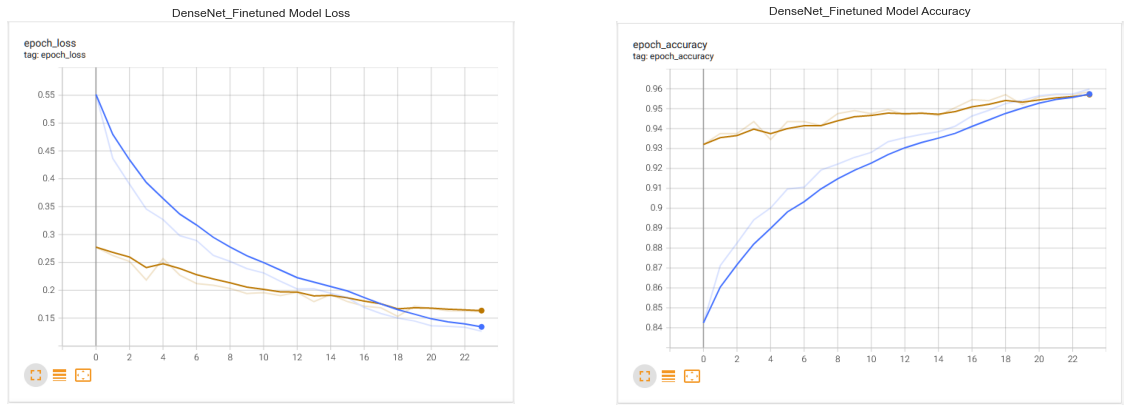

In [17]:
plt.figure(figsize = [20,15])
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread("data\models\\" + model_name + "\Loss.png", cv2.IMREAD_UNCHANGED))
plt.title(model_name + " Model Loss")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread("data\models\\" + model_name + "\Accuracy.png", cv2.IMREAD_UNCHANGED))
plt.title(model_name + " Model Accuracy")
plt.axis('off')
plt.show()

In [18]:
model5 = load_model("data/models/DenseNet_Finetuned/0.1531-0.9570.h5")
eval_test = model5.evaluate(test_dataloader, verbose = 0)
mod5_test_loss = eval_test[0]
mod5_test_acc = eval_test[1]

In [19]:
print("Finetuned DenseNet Model test loss:", mod5_test_loss,
      "\nFinetuned DenseNet Model test accuracy:", mod5_test_acc)

Finetuned DenseNet Model test loss: 0.09757063537836075 
Finetuned DenseNet Model test accuracy: 0.9725000262260437


<a id="mod6"></a>
#### <center>EfficientNet Frozen Model

[<div style="text-align: right"><font color="#000000">Back to Table of Content](#top)

Lastly, we will use EfficientNet for transfer learning. Similar to previous transfer learning models, we will use our own classifier on top of convolution base of the EfficientNet with imagenet weights loaded. We will also freeze the EfficientNet and train only the top classifier. We will use images resized to height of 128 and width of 128 for this model.

In [7]:
tf.keras.backend.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)
tf.random.set_seed(0)

In [8]:
model_name = "EfficientNet_Frozen"
threshold = 0.9
stop_patience = 5
schedule_lr_patience = 3
schedule_lr_factor = 0.9
reduce_lr_patience = 2
reduce_lr_factor = 0.5
h = 128
w = 128
BATCH_SIZE = 256

In [9]:
train_dataloader = data_generator(train_df, "Filepath", "Species", BATCH_SIZE, h, w, is_train = True)
valid_dataloader = data_generator(valid_df, "Filepath", "Species", BATCH_SIZE, h, w)
test_dataloader = data_generator(test_df, "Filepath", "Species", BATCH_SIZE, h, w)

Found 58388 validated image filenames belonging to 400 classes.
Found 2000 validated image filenames belonging to 400 classes.
Found 2000 validated image filenames belonging to 400 classes.


In [10]:
effnet_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(include_top = False, weights = 'imagenet',
                                                                        input_shape = (h, w, 3))
for layer in effnet_model.layers:
    layer.trainable = False

In [11]:
pool = AveragePooling2D(pool_size = (2, 2))(effnet_model.layers[-1].output)
conv = Conv2D(1024, 2, kernel_initializer = HeUniform(seed = 3))(pool)
bn = BatchNormalization()(conv)
act = Activation("relu")(bn)
flat = Flatten()(act)
drop = Dropout(0.1)(flat)
output_layer = Dense(num_class, activation = "softmax", kernel_initializer = GlorotUniform(seed = 6))(drop)

model6 = Model(inputs = effnet_model.inputs, outputs = output_layer, name = model_name)

In [12]:
try:
    os.mkdir("data/models/" + model_name)
except:
    ""
dot_img_file = 'data/models/' + model_name + '/Plot.png'
tf.keras.utils.plot_model(model6, to_file = dot_img_file, show_shapes = True)
model6.summary(show_trainable = True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.609653 to fit

Model: "EfficientNet_Frozen"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               N          
                                )]                                                                           
                                                                                                             
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                N          
                                                                                                             
 stem_conv (Conv2D)             (None, 64, 64, 24)   648         ['rescaling[0][0]']              N          
           

 block2c_expand_activation (Act  (None, 32, 32, 192)  0          ['block2c_expand_bn[0][0]']      N          
 ivation)                                                                                                    
                                                                                                             
 block2c_project_conv (Conv2D)  (None, 32, 32, 48)   9216        ['block2c_expand_activation[0][  N          
                                                                 0]']                                        
                                                                                                             
 block2c_project_bn (BatchNorma  (None, 32, 32, 48)  192         ['block2c_project_conv[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 block2c_a

                                                                  'block3b_add[0][0]']                       
                                                                                                             
 block3d_expand_conv (Conv2D)   (None, 16, 16, 256)  147456      ['block3c_add[0][0]']            N          
                                                                                                             
 block3d_expand_bn (BatchNormal  (None, 16, 16, 256)  1024       ['block3d_expand_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 block3d_expand_activation (Act  (None, 16, 16, 256)  0          ['block3d_expand_bn[0][0]']      N          
 ivation)                                                                                                    
          

 block4b_se_reduce (Conv2D)     (None, 1, 1, 32)     16416       ['block4b_se_reshape[0][0]']     N          
                                                                                                             
 block4b_se_expand (Conv2D)     (None, 1, 1, 512)    16896       ['block4b_se_reduce[0][0]']      N          
                                                                                                             
 block4b_se_excite (Multiply)   (None, 8, 8, 512)    0           ['block4b_activation[0][0]',     N          
                                                                  'block4b_se_expand[0][0]']                 
                                                                                                             
 block4b_project_conv (Conv2D)  (None, 8, 8, 128)    65536       ['block4b_se_excite[0][0]']      N          
                                                                                                             
 block4b_p

                                                                                                             
 block4d_se_expand (Conv2D)     (None, 1, 1, 512)    16896       ['block4d_se_reduce[0][0]']      N          
                                                                                                             
 block4d_se_excite (Multiply)   (None, 8, 8, 512)    0           ['block4d_activation[0][0]',     N          
                                                                  'block4d_se_expand[0][0]']                 
                                                                                                             
 block4d_project_conv (Conv2D)  (None, 8, 8, 128)    65536       ['block4d_se_excite[0][0]']      N          
                                                                                                             
 block4d_project_bn (BatchNorma  (None, 8, 8, 128)   512         ['block4d_project_conv[0][0]']   N          
 lization)

 block4f_se_expand (Conv2D)     (None, 1, 1, 512)    16896       ['block4f_se_reduce[0][0]']      N          
                                                                                                             
 block4f_se_excite (Multiply)   (None, 8, 8, 512)    0           ['block4f_activation[0][0]',     N          
                                                                  'block4f_se_expand[0][0]']                 
                                                                                                             
 block4f_project_conv (Conv2D)  (None, 8, 8, 128)    65536       ['block4f_se_excite[0][0]']      N          
                                                                                                             
 block4f_project_bn (BatchNorma  (None, 8, 8, 128)   512         ['block4f_project_conv[0][0]']   N          
 lization)                                                                                                   
          

                                                                                                             
 block5b_project_conv (Conv2D)  (None, 8, 8, 160)    153600      ['block5b_se_excite[0][0]']      N          
                                                                                                             
 block5b_project_bn (BatchNorma  (None, 8, 8, 160)   640         ['block5b_project_conv[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 block5b_add (Add)              (None, 8, 8, 160)    0           ['block5b_project_bn[0][0]',     N          
                                                                  'block5a_project_bn[0][0]']                
                                                                                                             
 block5c_e

 block5d_project_conv (Conv2D)  (None, 8, 8, 160)    153600      ['block5d_se_excite[0][0]']      N          
                                                                                                             
 block5d_project_bn (BatchNorma  (None, 8, 8, 160)   640         ['block5d_project_conv[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 block5d_add (Add)              (None, 8, 8, 160)    0           ['block5d_project_bn[0][0]',     N          
                                                                  'block5c_add[0][0]']                       
                                                                                                             
 block5e_expand_conv (Conv2D)   (None, 8, 8, 960)    153600      ['block5d_add[0][0]']            N          
          

                                                                                                             
 block5f_project_bn (BatchNorma  (None, 8, 8, 160)   640         ['block5f_project_conv[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 block5f_add (Add)              (None, 8, 8, 160)    0           ['block5f_project_bn[0][0]',     N          
                                                                  'block5e_add[0][0]']                       
                                                                                                             
 block5g_expand_conv (Conv2D)   (None, 8, 8, 960)    153600      ['block5f_add[0][0]']            N          
                                                                                                             
 block5g_e

 block5h_project_bn (BatchNorma  (None, 8, 8, 160)   640         ['block5h_project_conv[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 block5h_add (Add)              (None, 8, 8, 160)    0           ['block5h_project_bn[0][0]',     N          
                                                                  'block5g_add[0][0]']                       
                                                                                                             
 block5i_expand_conv (Conv2D)   (None, 8, 8, 960)    153600      ['block5h_add[0][0]']            N          
                                                                                                             
 block5i_expand_bn (BatchNormal  (None, 8, 8, 960)   3840        ['block5i_expand_conv[0][0]']    N          
 ization) 

 lization)                                                                                                   
                                                                                                             
 block6b_expand_conv (Conv2D)   (None, 4, 4, 1536)   393216      ['block6a_project_bn[0][0]']     N          
                                                                                                             
 block6b_expand_bn (BatchNormal  (None, 4, 4, 1536)  6144        ['block6b_expand_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 block6b_expand_activation (Act  (None, 4, 4, 1536)  0           ['block6b_expand_bn[0][0]']      N          
 ivation)                                                                                                    
          

                                                                                                             
 block6d_expand_conv (Conv2D)   (None, 4, 4, 1536)   393216      ['block6c_add[0][0]']            N          
                                                                                                             
 block6d_expand_bn (BatchNormal  (None, 4, 4, 1536)  6144        ['block6d_expand_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 block6d_expand_activation (Act  (None, 4, 4, 1536)  0           ['block6d_expand_bn[0][0]']      N          
 ivation)                                                                                                    
                                                                                                             
 block6d_d

 block6f_expand_conv (Conv2D)   (None, 4, 4, 1536)   393216      ['block6e_add[0][0]']            N          
                                                                                                             
 block6f_expand_bn (BatchNormal  (None, 4, 4, 1536)  6144        ['block6f_expand_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 block6f_expand_activation (Act  (None, 4, 4, 1536)  0           ['block6f_expand_bn[0][0]']      N          
 ivation)                                                                                                    
                                                                                                             
 block6f_dwconv2 (DepthwiseConv  (None, 4, 4, 1536)  13824       ['block6f_expand_activation[0][  N          
 2D)      

                                                                                                             
 block6h_expand_bn (BatchNormal  (None, 4, 4, 1536)  6144        ['block6h_expand_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 block6h_expand_activation (Act  (None, 4, 4, 1536)  0           ['block6h_expand_bn[0][0]']      N          
 ivation)                                                                                                    
                                                                                                             
 block6h_dwconv2 (DepthwiseConv  (None, 4, 4, 1536)  13824       ['block6h_expand_activation[0][  N          
 2D)                                                             0]']                                        
          

 block6j_expand_bn (BatchNormal  (None, 4, 4, 1536)  6144        ['block6j_expand_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 block6j_expand_activation (Act  (None, 4, 4, 1536)  0           ['block6j_expand_bn[0][0]']      N          
 ivation)                                                                                                    
                                                                                                             
 block6j_dwconv2 (DepthwiseConv  (None, 4, 4, 1536)  13824       ['block6j_expand_activation[0][  N          
 2D)                                                             0]']                                        
                                                                                                             
 block6j_b

 ization)                                                                                                    
                                                                                                             
 block6l_expand_activation (Act  (None, 4, 4, 1536)  0           ['block6l_expand_bn[0][0]']      N          
 ivation)                                                                                                    
                                                                                                             
 block6l_dwconv2 (DepthwiseConv  (None, 4, 4, 1536)  13824       ['block6l_expand_activation[0][  N          
 2D)                                                             0]']                                        
                                                                                                             
 block6l_bn (BatchNormalization  (None, 4, 4, 1536)  6144        ['block6l_dwconv2[0][0]']        N          
 )        

                                                                                                             
 block6n_expand_activation (Act  (None, 4, 4, 1536)  0           ['block6n_expand_bn[0][0]']      N          
 ivation)                                                                                                    
                                                                                                             
 block6n_dwconv2 (DepthwiseConv  (None, 4, 4, 1536)  13824       ['block6n_expand_activation[0][  N          
 2D)                                                             0]']                                        
                                                                                                             
 block6n_bn (BatchNormalization  (None, 4, 4, 1536)  6144        ['block6n_dwconv2[0][0]']        N          
 )                                                                                                           
          

                                                                                                             
 average_pooling2d (AveragePool  (None, 2, 2, 1280)  0           ['top_activation[0][0]']         Y          
 ing2D)                                                                                                      
                                                                                                             
 conv2d (Conv2D)                (None, 1, 1, 1024)   5243904     ['average_pooling2d[0][0]']      Y          
                                                                                                             
 batch_normalization (BatchNorm  (None, 1, 1, 1024)  4096        ['conv2d[0][0]']                 Y          
 alization)                                                                                                  
                                                                                                             
 activatio

In [13]:
optimizer = Adam(0.01)
callback_lst = callbacks(model_name, threshold, stop_patience, schedule_lr_patience, schedule_lr_factor, reduce_lr_patience,
                         reduce_lr_factor)
model6.compile(optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [14]:
%%time
model6.fit(train_dataloader, steps_per_epoch = len(train_dataloader), epochs = 50, validation_data = valid_dataloader,
           callbacks = callback_lst)

Epoch 1/50
229/229 [==============================] - 717s 3s/step - loss: 2.6025 - accuracy: 0.4280 - val_loss: 0.9644 - val_accuracy: 0.7310 - lr: 0.0100 - next_lr: 0.0100 - best_val_accuracy: 0.7310 - best_val_loss: 0.9644 - best_epoch: 1.0000
Epoch 2/50
229/229 [==============================] - 370s 2s/step - loss: 1.5864 - accuracy: 0.6002 - val_loss: 0.6643 - val_accuracy: 0.8060 - lr: 0.0100 - next_lr: 0.0100 - best_val_accuracy: 0.8060 - best_val_loss: 0.6643 - best_epoch: 2.0000
Epoch 3/50
229/229 [==============================] - 376s 2s/step - loss: 1.3710 - accuracy: 0.6487 - val_loss: 0.5387 - val_accuracy: 0.8545 - lr: 0.0100 - next_lr: 0.0090 - best_val_accuracy: 0.8545 - best_val_loss: 0.5387 - best_epoch: 3.0000
Epoch 4/50
229/229 [==============================] - 372s 2s/step - loss: 1.2144 - accuracy: 0.6834 - val_loss: 0.4891 - val_accuracy: 0.8580 - lr: 0.0090 - next_lr: 0.0090 - best_val_accuracy: 0.8580 - best_val_loss: 0.4891 - best_epoch: 4.0000
Epoch 5/50
2

Epoch 34/50
229/229 [==============================] - 371s 2s/step - loss: 0.4088 - accuracy: 0.8811 - val_loss: 0.2243 - val_accuracy: 0.9335 - lr: 3.9226e-04 - next_lr: 3.9226e-04 - best_val_accuracy: 0.9340 - best_val_loss: 0.2229 - best_epoch: 33.0000
Epoch 35/50
229/229 [==============================] - 369s 2s/step - loss: 0.4056 - accuracy: 0.8830 - val_loss: 0.2236 - val_accuracy: 0.9335 - lr: 3.9226e-04 - next_lr: 1.9613e-04 - best_val_accuracy: 0.9340 - best_val_loss: 0.2229 - best_epoch: 33.0000
Epoch 36/50
229/229 [==============================] - 370s 2s/step - loss: 0.4066 - accuracy: 0.8822 - val_loss: 0.2225 - val_accuracy: 0.9315 - lr: 1.9613e-04 - next_lr: 1.7652e-04 - best_val_accuracy: 0.9340 - best_val_loss: 0.2225 - best_epoch: 36.0000
Epoch 37/50
229/229 [==============================] - 370s 2s/step - loss: 0.3992 - accuracy: 0.8848 - val_loss: 0.2206 - val_accuracy: 0.9355 - lr: 1.7652e-04 - next_lr: 1.7652e-04 - best_val_accuracy: 0.9355 - best_val_loss: 0

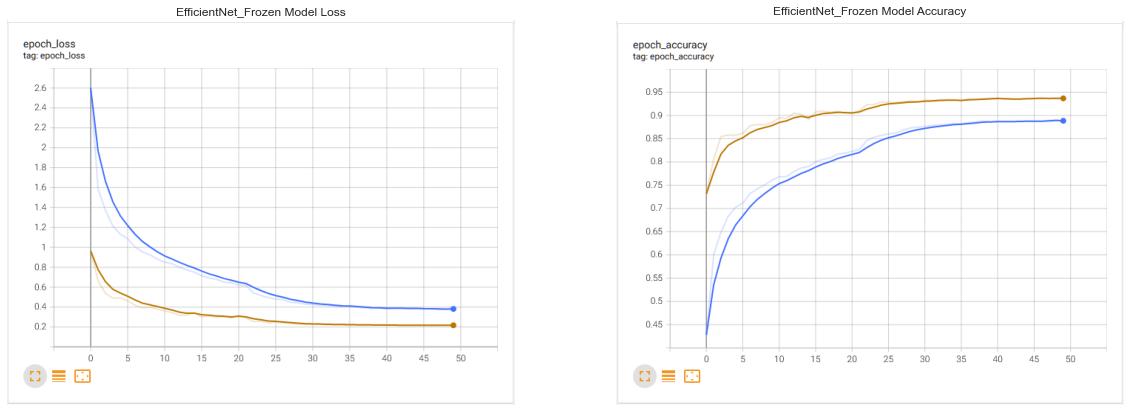

In [15]:
plt.figure(figsize = [20,15])
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread("data\models\\" + model_name + "\Loss.png", cv2.IMREAD_UNCHANGED))
plt.title(model_name + " Model Loss")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread("data\models\\" + model_name + "\Accuracy.png", cv2.IMREAD_UNCHANGED))
plt.title(model_name + " Model Accuracy")
plt.axis('off')
plt.show()

In [16]:
model6 = load_model("data/models/EfficientNet_Frozen/0.2171-0.9380.h5")
eval_test = model6.evaluate(test_dataloader, verbose = 0)
mod6_test_loss = eval_test[0]
mod6_test_acc = eval_test[1]

In [17]:
print("EfficientNet Model with Convolution Base frozen test loss:", mod6_test_loss,
      "\nEfficientNet Model with Convolution Base frozen test accuracy:", mod6_test_acc)

EfficientNet Model with Convolution Base frozen test loss: 0.16626784205436707 
EfficientNet Model with Convolution Base frozen test accuracy: 0.9509999752044678


<a id="mod7"></a>
#### <center>EfficientNet Finetuned Model

[<div style="text-align: right"><font color="#000000">Back to Table of Content](#top)

To improve our EfficientNet model's performance, we will fine-tune the Block 6 of the EfficientNet alongside the top-level classifier. We will load the weights from the previously trained EfficientNet model with frozen Convolution Base and then re-train the model using very small weight updates.

In [7]:
tf.keras.backend.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)
tf.random.set_seed(0)

In [8]:
model_name = "EfficientNet_Finetuned"
threshold = 0.9
stop_patience = 5
schedule_lr_patience = 3
schedule_lr_factor = 0.9
reduce_lr_patience = 2
reduce_lr_factor = 0.5
h = 128
w = 128
BATCH_SIZE = 32

In [9]:
train_dataloader = data_generator(train_df, "Filepath", "Species", BATCH_SIZE, h, w, is_train = True)
valid_dataloader = data_generator(valid_df, "Filepath", "Species", BATCH_SIZE, h, w)
test_dataloader = data_generator(test_df, "Filepath", "Species", BATCH_SIZE, h, w)

Found 58388 validated image filenames belonging to 400 classes.
Found 2000 validated image filenames belonging to 400 classes.
Found 2000 validated image filenames belonging to 400 classes.


In [10]:
effnet_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(include_top = False, weights = 'imagenet',
                                                                        input_shape = (h, w, 3))
for layer in effnet_model.layers[:-212]:
    layer.trainable = False

In [11]:
pool = AveragePooling2D(pool_size = (2, 2))(effnet_model.layers[-1].output)
conv = Conv2D(1024, 2, kernel_initializer = HeUniform(seed = 3))(pool)
bn = BatchNormalization()(conv)
act = Activation("relu")(bn)
flat = Flatten()(act)
drop = Dropout(0.1)(flat)
output_layer = Dense(num_class, activation = "softmax", kernel_initializer = GlorotUniform(seed = 6))(drop)

model7 = Model(inputs = effnet_model.inputs, outputs = output_layer, name = model_name)

In [12]:
model7.load_weights("data/models/EfficientNet_Frozen/0.2171-0.9380.h5")

In [13]:
try:
    os.mkdir("data/models/" + model_name)
except:
    ""
dot_img_file = 'data/models/' + model_name + '/Plot.png'
tf.keras.utils.plot_model(model7, to_file = dot_img_file, show_shapes = True)
model7.summary(show_trainable = True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.609653 to fit

Model: "EfficientNet_Finetuned"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               N          
                                )]                                                                           
                                                                                                             
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                N          
                                                                                                             
 stem_conv (Conv2D)             (None, 64, 64, 24)   648         ['rescaling[0][0]']              N          
        

 block2c_expand_activation (Act  (None, 32, 32, 192)  0          ['block2c_expand_bn[0][0]']      N          
 ivation)                                                                                                    
                                                                                                             
 block2c_project_conv (Conv2D)  (None, 32, 32, 48)   9216        ['block2c_expand_activation[0][  N          
                                                                 0]']                                        
                                                                                                             
 block2c_project_bn (BatchNorma  (None, 32, 32, 48)  192         ['block2c_project_conv[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 block2c_a

                                                                  'block3b_add[0][0]']                       
                                                                                                             
 block3d_expand_conv (Conv2D)   (None, 16, 16, 256)  147456      ['block3c_add[0][0]']            N          
                                                                                                             
 block3d_expand_bn (BatchNormal  (None, 16, 16, 256)  1024       ['block3d_expand_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 block3d_expand_activation (Act  (None, 16, 16, 256)  0          ['block3d_expand_bn[0][0]']      N          
 ivation)                                                                                                    
          

 block4b_se_reduce (Conv2D)     (None, 1, 1, 32)     16416       ['block4b_se_reshape[0][0]']     N          
                                                                                                             
 block4b_se_expand (Conv2D)     (None, 1, 1, 512)    16896       ['block4b_se_reduce[0][0]']      N          
                                                                                                             
 block4b_se_excite (Multiply)   (None, 8, 8, 512)    0           ['block4b_activation[0][0]',     N          
                                                                  'block4b_se_expand[0][0]']                 
                                                                                                             
 block4b_project_conv (Conv2D)  (None, 8, 8, 128)    65536       ['block4b_se_excite[0][0]']      N          
                                                                                                             
 block4b_p

                                                                                                             
 block4d_se_expand (Conv2D)     (None, 1, 1, 512)    16896       ['block4d_se_reduce[0][0]']      N          
                                                                                                             
 block4d_se_excite (Multiply)   (None, 8, 8, 512)    0           ['block4d_activation[0][0]',     N          
                                                                  'block4d_se_expand[0][0]']                 
                                                                                                             
 block4d_project_conv (Conv2D)  (None, 8, 8, 128)    65536       ['block4d_se_excite[0][0]']      N          
                                                                                                             
 block4d_project_bn (BatchNorma  (None, 8, 8, 128)   512         ['block4d_project_conv[0][0]']   N          
 lization)

 block4f_se_expand (Conv2D)     (None, 1, 1, 512)    16896       ['block4f_se_reduce[0][0]']      N          
                                                                                                             
 block4f_se_excite (Multiply)   (None, 8, 8, 512)    0           ['block4f_activation[0][0]',     N          
                                                                  'block4f_se_expand[0][0]']                 
                                                                                                             
 block4f_project_conv (Conv2D)  (None, 8, 8, 128)    65536       ['block4f_se_excite[0][0]']      N          
                                                                                                             
 block4f_project_bn (BatchNorma  (None, 8, 8, 128)   512         ['block4f_project_conv[0][0]']   N          
 lization)                                                                                                   
          

                                                                                                             
 block5b_project_conv (Conv2D)  (None, 8, 8, 160)    153600      ['block5b_se_excite[0][0]']      N          
                                                                                                             
 block5b_project_bn (BatchNorma  (None, 8, 8, 160)   640         ['block5b_project_conv[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 block5b_add (Add)              (None, 8, 8, 160)    0           ['block5b_project_bn[0][0]',     N          
                                                                  'block5a_project_bn[0][0]']                
                                                                                                             
 block5c_e

 block5d_project_conv (Conv2D)  (None, 8, 8, 160)    153600      ['block5d_se_excite[0][0]']      N          
                                                                                                             
 block5d_project_bn (BatchNorma  (None, 8, 8, 160)   640         ['block5d_project_conv[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 block5d_add (Add)              (None, 8, 8, 160)    0           ['block5d_project_bn[0][0]',     N          
                                                                  'block5c_add[0][0]']                       
                                                                                                             
 block5e_expand_conv (Conv2D)   (None, 8, 8, 960)    153600      ['block5d_add[0][0]']            N          
          

                                                                                                             
 block5f_project_bn (BatchNorma  (None, 8, 8, 160)   640         ['block5f_project_conv[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 block5f_add (Add)              (None, 8, 8, 160)    0           ['block5f_project_bn[0][0]',     N          
                                                                  'block5e_add[0][0]']                       
                                                                                                             
 block5g_expand_conv (Conv2D)   (None, 8, 8, 960)    153600      ['block5f_add[0][0]']            N          
                                                                                                             
 block5g_e

 block5h_project_bn (BatchNorma  (None, 8, 8, 160)   640         ['block5h_project_conv[0][0]']   N          
 lization)                                                                                                   
                                                                                                             
 block5h_add (Add)              (None, 8, 8, 160)    0           ['block5h_project_bn[0][0]',     N          
                                                                  'block5g_add[0][0]']                       
                                                                                                             
 block5i_expand_conv (Conv2D)   (None, 8, 8, 960)    153600      ['block5h_add[0][0]']            N          
                                                                                                             
 block5i_expand_bn (BatchNormal  (None, 8, 8, 960)   3840        ['block5i_expand_conv[0][0]']    N          
 ization) 

 lization)                                                                                                   
                                                                                                             
 block6b_expand_conv (Conv2D)   (None, 4, 4, 1536)   393216      ['block6a_project_bn[0][0]']     Y          
                                                                                                             
 block6b_expand_bn (BatchNormal  (None, 4, 4, 1536)  6144        ['block6b_expand_conv[0][0]']    Y          
 ization)                                                                                                    
                                                                                                             
 block6b_expand_activation (Act  (None, 4, 4, 1536)  0           ['block6b_expand_bn[0][0]']      Y          
 ivation)                                                                                                    
          

                                                                                                             
 block6d_expand_conv (Conv2D)   (None, 4, 4, 1536)   393216      ['block6c_add[0][0]']            Y          
                                                                                                             
 block6d_expand_bn (BatchNormal  (None, 4, 4, 1536)  6144        ['block6d_expand_conv[0][0]']    Y          
 ization)                                                                                                    
                                                                                                             
 block6d_expand_activation (Act  (None, 4, 4, 1536)  0           ['block6d_expand_bn[0][0]']      Y          
 ivation)                                                                                                    
                                                                                                             
 block6d_d

 block6f_expand_conv (Conv2D)   (None, 4, 4, 1536)   393216      ['block6e_add[0][0]']            Y          
                                                                                                             
 block6f_expand_bn (BatchNormal  (None, 4, 4, 1536)  6144        ['block6f_expand_conv[0][0]']    Y          
 ization)                                                                                                    
                                                                                                             
 block6f_expand_activation (Act  (None, 4, 4, 1536)  0           ['block6f_expand_bn[0][0]']      Y          
 ivation)                                                                                                    
                                                                                                             
 block6f_dwconv2 (DepthwiseConv  (None, 4, 4, 1536)  13824       ['block6f_expand_activation[0][  Y          
 2D)      

                                                                                                             
 block6h_expand_bn (BatchNormal  (None, 4, 4, 1536)  6144        ['block6h_expand_conv[0][0]']    Y          
 ization)                                                                                                    
                                                                                                             
 block6h_expand_activation (Act  (None, 4, 4, 1536)  0           ['block6h_expand_bn[0][0]']      Y          
 ivation)                                                                                                    
                                                                                                             
 block6h_dwconv2 (DepthwiseConv  (None, 4, 4, 1536)  13824       ['block6h_expand_activation[0][  Y          
 2D)                                                             0]']                                        
          

 block6j_expand_bn (BatchNormal  (None, 4, 4, 1536)  6144        ['block6j_expand_conv[0][0]']    Y          
 ization)                                                                                                    
                                                                                                             
 block6j_expand_activation (Act  (None, 4, 4, 1536)  0           ['block6j_expand_bn[0][0]']      Y          
 ivation)                                                                                                    
                                                                                                             
 block6j_dwconv2 (DepthwiseConv  (None, 4, 4, 1536)  13824       ['block6j_expand_activation[0][  Y          
 2D)                                                             0]']                                        
                                                                                                             
 block6j_b

 ization)                                                                                                    
                                                                                                             
 block6l_expand_activation (Act  (None, 4, 4, 1536)  0           ['block6l_expand_bn[0][0]']      Y          
 ivation)                                                                                                    
                                                                                                             
 block6l_dwconv2 (DepthwiseConv  (None, 4, 4, 1536)  13824       ['block6l_expand_activation[0][  Y          
 2D)                                                             0]']                                        
                                                                                                             
 block6l_bn (BatchNormalization  (None, 4, 4, 1536)  6144        ['block6l_dwconv2[0][0]']        Y          
 )        

                                                                                                             
 block6n_expand_activation (Act  (None, 4, 4, 1536)  0           ['block6n_expand_bn[0][0]']      Y          
 ivation)                                                                                                    
                                                                                                             
 block6n_dwconv2 (DepthwiseConv  (None, 4, 4, 1536)  13824       ['block6n_expand_activation[0][  Y          
 2D)                                                             0]']                                        
                                                                                                             
 block6n_bn (BatchNormalization  (None, 4, 4, 1536)  6144        ['block6n_dwconv2[0][0]']        Y          
 )                                                                                                           
          

                                                                                                             
 average_pooling2d (AveragePool  (None, 2, 2, 1280)  0           ['top_activation[0][0]']         Y          
 ing2D)                                                                                                      
                                                                                                             
 conv2d (Conv2D)                (None, 1, 1, 1024)   5243904     ['average_pooling2d[0][0]']      Y          
                                                                                                             
 batch_normalization (BatchNorm  (None, 1, 1, 1024)  4096        ['conv2d[0][0]']                 Y          
 alization)                                                                                                  
                                                                                                             
 activatio

In [14]:
optimizer = Adam(0.0001)
callback_lst = callbacks(model_name, threshold, stop_patience, schedule_lr_patience, schedule_lr_factor, reduce_lr_patience,
                         reduce_lr_factor)
model7.compile(optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [15]:
%%time
model7.fit(train_dataloader, steps_per_epoch = len(train_dataloader), epochs = 50, validation_data = valid_dataloader,
           callbacks = callback_lst)

Epoch 1/50
1825/1825 [==============================] - 512s 272ms/step - loss: 0.8420 - accuracy: 0.7787 - val_loss: 0.2456 - val_accuracy: 0.9290 - lr: 1.0000e-04 - next_lr: 1.0000e-04 - best_val_accuracy: 0.9290 - best_val_loss: 0.2456 - best_epoch: 1.0000
Epoch 2/50
1825/1825 [==============================] - 490s 268ms/step - loss: 0.4832 - accuracy: 0.8620 - val_loss: 0.2457 - val_accuracy: 0.9290 - lr: 1.0000e-04 - next_lr: 1.0000e-04 - best_val_accuracy: 0.9290 - best_val_loss: 0.2456 - best_epoch: 1.0000
Epoch 3/50
1825/1825 [==============================] - 492s 270ms/step - loss: 0.3826 - accuracy: 0.8882 - val_loss: 0.2180 - val_accuracy: 0.9345 - lr: 1.0000e-04 - next_lr: 9.0000e-05 - best_val_accuracy: 0.9345 - best_val_loss: 0.2180 - best_epoch: 3.0000
Epoch 4/50
1825/1825 [==============================] - 493s 270ms/step - loss: 0.3311 - accuracy: 0.9014 - val_loss: 0.1841 - val_accuracy: 0.9425 - lr: 9.0000e-05 - next_lr: 9.0000e-05 - best_val_accuracy: 0.9425 - bes

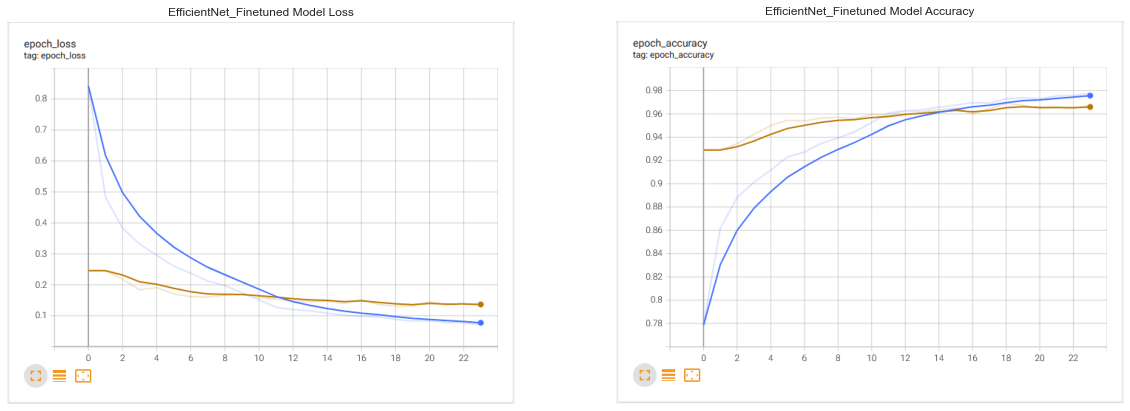

In [16]:
plt.figure(figsize = [20,15])
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread("data\models\\" + model_name + "\Loss.png", cv2.IMREAD_UNCHANGED))
plt.title(model_name + " Model Loss")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread("data\models\\" + model_name + "\Accuracy.png", cv2.IMREAD_UNCHANGED))
plt.title(model_name + " Model Accuracy")
plt.axis('off')
plt.show()

In [17]:
model7 = load_model("data/models/EfficientNet_Finetuned/0.1316-0.9690.h5")
eval_test = model7.evaluate(test_dataloader, verbose = 0)
mod7_test_loss = eval_test[0]
mod7_test_acc = eval_test[1]

In [18]:
print("Finetuned EfficientNet Model test loss:", mod7_test_loss,
      "\nFinetuned EfficientNet Model test accuracy:", mod7_test_acc)

Finetuned EfficientNet Model test loss: 0.09074142575263977 
Finetuned EfficientNet Model test accuracy: 0.9754999876022339


<a id="summary"></a>
### <center>Summary of Performance of all Models

[<div style="text-align: right"><font color="#000000">Back to Table of Content](#top)

In [4]:
myTable = PrettyTable(["Model", "Test Loss", "Test Accuracy"])
myTable.add_row(["Random", ran_test_loss, ran_test_acc])
myTable.add_row(["Simple Convolution", mod1_test_loss, mod1_test_acc])
myTable.add_row(["Inception Frozen", mod2_test_loss, mod2_test_acc])
myTable.add_row(["Inception Finetuned", mod3_test_loss, mod3_test_acc])
myTable.add_row(["DenseNet Frozen", mod4_test_loss, mod4_test_acc])
myTable.add_row(["DenseNet Finetuned", mod5_test_loss, mod5_test_acc])
myTable.add_row(["EfficientNet Frozen", mod6_test_loss, mod6_test_acc])
myTable.add_row(["EfficientNet Finetuned", mod7_test_loss, mod7_test_acc])
print(myTable)

+------------------------+---------------------+--------------------+
|         Model          |      Test Loss      |   Test Accuracy    |
+------------------------+---------------------+--------------------+
|         Random         |  6.316259193302194  |       0.0035       |
|   Simple Convolution   |  1.1851749420166016 | 0.6890000104904175 |
|    Inception Frozen    |  0.6430472135543823 | 0.8180000185966492 |
|  Inception Finetuned   | 0.12416183948516846 | 0.9670000076293945 |
|    DenseNet Frozen     |  0.1348697543144226 | 0.9574999809265137 |
|   DenseNet Finetuned   | 0.09757063537836075 | 0.9725000262260437 |
|  EfficientNet Frozen   | 0.16626784205436707 | 0.9509999752044678 |
| EfficientNet Finetuned | 0.09074142575263977 | 0.9754999876022339 |
+------------------------+---------------------+--------------------+


Of all the models we have trained, Transfer Learning with Finetuned EfficientNet model with our own classifier on top has the best performance with lowest cross-entropy and highest accuracy on test images. We will use this EfficientNet Model for deployment of our Bird Species Identification web-app.

<a id="error"></a>
### <center>Error Analysis

[<div style="text-align: right"><font color="#000000">Back to Table of Content](#top)

In [28]:
height = 128
width = 128
model = load_model("data/models/EfficientNet_Finetuned/0.1316-0.9690.h5")

In [29]:
class_rep, error_rep, acc_count, err_count, acc = report(test_df, 'Filepath', 'Label', model, classes, height, width)

In [30]:
print("Total number of correctly predicted Images:", acc_count)
print("Total number of incorrectly predicted Images:", err_count)
print("Accuracy of the Model:", acc)

Total number of correctly predicted Images: 1954
Total number of incorrectly predicted Images: 46
Accuracy of the Model: 97.7


In [31]:
print("Classification Report:")
print("-" * 90)
print(class_rep.to_string())

Classification Report:
------------------------------------------------------------------------------------------
                         Species  Total_Images  TP  FP  FN  Precision  Recall  F1-Score
0                ABBOTTS BABBLER             5   4   1   1       0.80     0.8      0.80
1                  ABBOTTS BOOBY             5   5   0   0       1.00     1.0      1.00
2     ABYSSINIAN GROUND HORNBILL             5   5   0   0       1.00     1.0      1.00
3          AFRICAN CROWNED CRANE             5   5   0   0       1.00     1.0      1.00
4         AFRICAN EMERALD CUCKOO             5   5   0   0       1.00     1.0      1.00
5              AFRICAN FIREFINCH             5   5   0   0       1.00     1.0      1.00
6         AFRICAN OYSTER CATCHER             5   5   0   0       1.00     1.0      1.00
7                      ALBATROSS             5   5   0   0       1.00     1.0      1.00
8                 ALBERTS TOWHEE             5   5   0   0       1.00     1.0      1.00
9     

In [32]:
num_error_class = class_rep[class_rep['F1-Score'] < 1].shape[0]
print("Number of Species having F1-Score less than 1 is", num_error_class)

Number of Species having F1-Score less than 1 is 76


In [33]:
sorted_class_rep = class_rep.sort_values(by = ['F1-Score'])
print("Top 10 Species with smallest F1-Score:")
print("-" * 84)
print(sorted_class_rep.head(10).to_string())

Top 10 Species with smallest F1-Score:
------------------------------------------------------------------------------------
                      Species  Total_Images  TP  FP  FN  Precision  Recall  F1-Score
358          STRAWBERRY FINCH             5   2   0   3       1.00     0.4      0.57
33                   AVADAVAT             5   4   3   1       0.57     0.8      0.67
148  DOUBLE BRESTED CORMARANT             5   3   0   2       1.00     0.6      0.75
255              MAGPIE GOOSE             5   5   3   0       0.62     1.0      0.77
0             ABBOTTS BABBLER             5   4   1   1       0.80     0.8      0.80
28                    APAPANE             5   4   1   1       0.80     0.8      0.80
29                APOSTLEBIRD             5   4   1   1       0.80     0.8      0.80
371         TOWNSENDS WARBLER             5   4   1   1       0.80     0.8      0.80
79           BORNEAN LEAFBIRD             5   4   1   1       0.80     0.8      0.80
306          PYGMY KINGFIS

In [34]:
print("Error Report:")
print("-" * 97)
print(error_rep.to_string())

Error Report:
-------------------------------------------------------------------------------------------------
                                   Image_Path        Predicted Species               True Species
0             data\test\ABBOTTS BABBLER\4.jpg           BROWN THRASHER            ABBOTTS BABBLER
1              data\test\AMERICAN PIPIT\5.jpg              HOUSE FINCH             AMERICAN PIPIT
2           data\test\AMETHYST WOODSTAR\5.jpg        ANNAS HUMMINGBIRD          AMETHYST WOODSTAR
3                data\test\ANDEAN GOOSE\5.jpg             MAGPIE GOOSE               ANDEAN GOOSE
4          data\test\ANTILLEAN EUPHONIA\4.jpg         BORNEAN LEAFBIRD         ANTILLEAN EUPHONIA
5                     data\test\APAPANE\4.jpg          HEPATIC TANAGER                    APAPANE
6                 data\test\APOSTLEBIRD\2.jpg          ABBOTTS BABBLER                APOSTLEBIRD
7                    data\test\AVADAVAT\4.jpg        TROPICAL KINGBIRD                   AVADAVAT
8     

On analysing Classification report and Error report, we find that the Species "AVADAVAT" and "STRAWBERRY FINCH" are the most responsible for degrading our model's performance. More than half of the "STRAWBERRY FINCH" images are predicted as "AVADAVAT" affecting their Recall and Precision respectively in-turn degrading their and model's F1-Score.

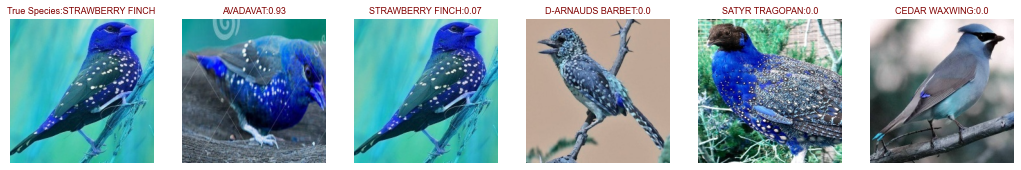

In [35]:
analyze(error_rep['Image_Path'][39], test_df, 'Filepath', 'Species', model, error_rep['True Species'][39], classes,
        height, width)

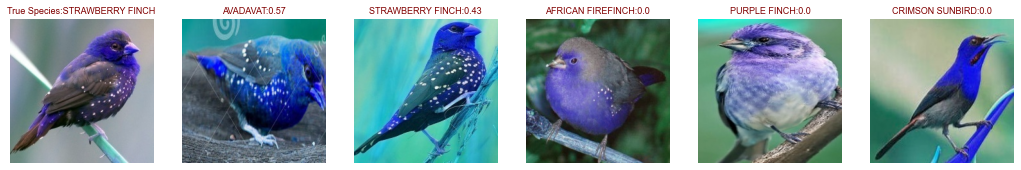

In [36]:
analyze(error_rep['Image_Path'][40], test_df, 'Filepath', 'Species', model, error_rep['True Species'][40], classes,
        height, width)

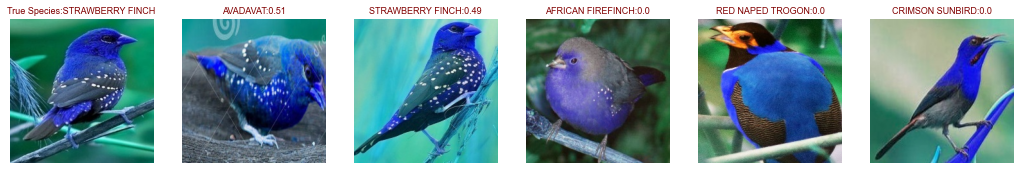

In [37]:
analyze(error_rep['Image_Path'][41], test_df, 'Filepath', 'Species', model, error_rep['True Species'][41], classes,
        height, width)

As we can see, all three wrong predictions for "STRAWBERRY FINCH" species are due to their similarity with "AVADAVAT" species having similar blue color with white dots.

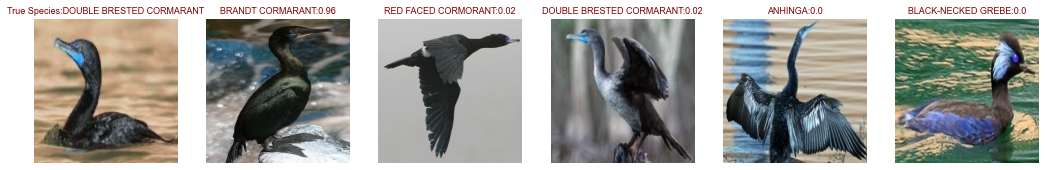

In [38]:
analyze(error_rep['Image_Path'][20], test_df, 'Filepath', 'Species', model, error_rep['True Species'][20], classes,
        height, width)

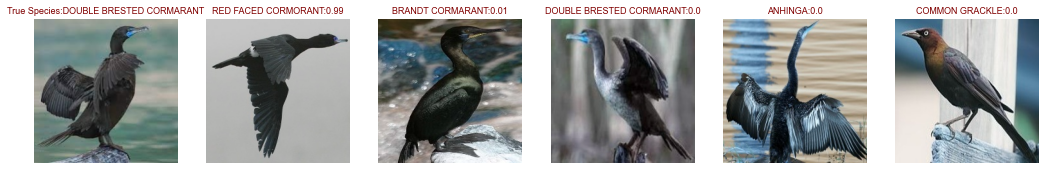

In [39]:
analyze(error_rep['Image_Path'][21], test_df, 'Filepath', 'Species', model, error_rep['True Species'][21], classes,
        height, width)

Also for "DOUBLE BRESTED CORMARANT", the two wrong predictions may be due to the similar black color with long neck.

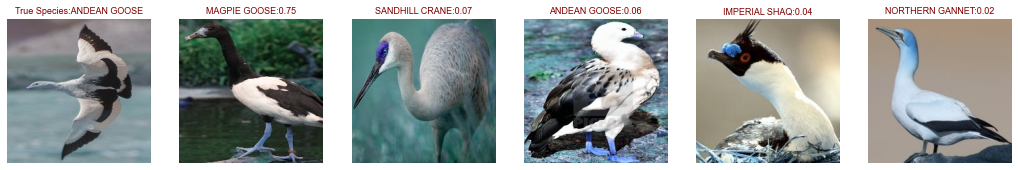

In [40]:
analyze(error_rep['Image_Path'][3], test_df, 'Filepath', 'Species', model, error_rep['True Species'][3], classes,
        height, width)

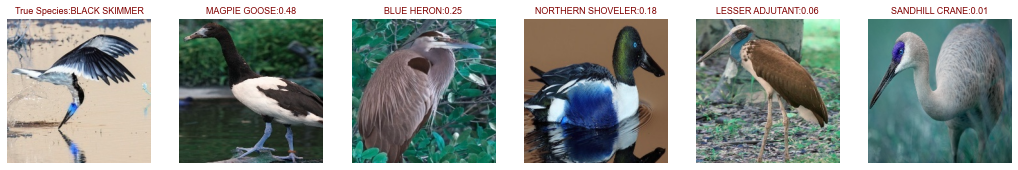

In [41]:
analyze(error_rep['Image_Path'][10], test_df, 'Filepath', 'Species', model, error_rep['True Species'][10], classes,
        height, width)

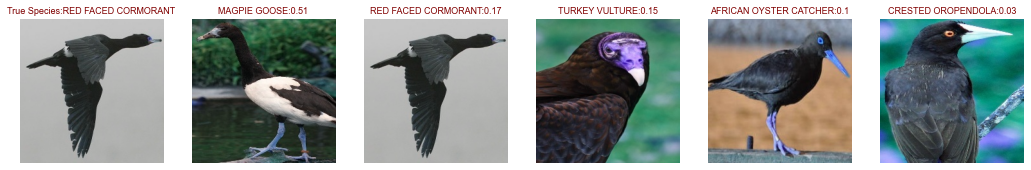

In [42]:
analyze(error_rep['Image_Path'][36], test_df, 'Filepath', 'Species', model, error_rep['True Species'][36], classes,
        height, width)

Three images, one each from "ANDEAN GOOSE", "BLACK SKIMMER" and "RED FACED CORMORANT" have been wrongly predicted as "MAGPIE GOOSE" by our model because of similar black and white shade in birds.

<a id="conclusions"></a>
### <center>Conclusions

[<div style="text-align: right"><font color="#000000">Back to Table of Content](#top)

1. The best model for classifying the bird species with lowest cross-entropy and highest accuracy was found to be EfficientNet Model. Block 6 of the EfficientNet along with our own classifier on top were trained while the rest of the EfficientNet Blocks were frozen.
2. Performing augmentation on train dataset helped us to artificially increase the train dataset size reducing overfitting of the model thus reducing generalisation error.
3. Out of 2000 total test images, 46 images were incorrectly predicted by our model mainly due to the similar color and form of the birds.